In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import warnings
from scipy.optimize import curve_fit
from scipy import integrate, stats
import natural_cubic_spline_stack_overflow as ncs
import dynamic_stock_model as dsm 
warnings.simplefilter(action='ignore', category=FutureWarning)

# DSM Results

In [3]:
TYP = ['TOT','AB','MFH','SFH','TH']

DSM_AB = pd.read_csv("Model/DSM_model_AB.csv")
DSM_AB = DSM_AB.set_index('Unnamed: 0')
DSM_AB.index.name = 'DSM AB'
DSM_MFH = pd.read_csv("Model/DSM_model_MFH.csv")
DSM_MFH = DSM_MFH.set_index('Unnamed: 0')
DSM_MFH.index.name = 'DSM MFH'
DSM_SFH = pd.read_csv("Model/DSM_model_SFH.csv")
DSM_SFH = DSM_SFH.set_index('Unnamed: 0')
DSM_SFH.index.name = 'DSM SFH'
DSM_TH = pd.read_csv("Model/DSM_model_TH.csv")
DSM_TH = DSM_TH.set_index('Unnamed: 0')
DSM_TH.index.name = 'DSM TH'

display(DSM_TH)

DSM = DSM_AB.copy(deep=True)
DSM['Stock'] = DSM_AB['Stock']+DSM_MFH['Stock']+DSM_SFH['Stock']+DSM_TH['Stock']
DSM['Stock Change'] = DSM_AB['Stock Change']+DSM_MFH['Stock Change']+DSM_SFH['Stock Change']+DSM_TH['Stock Change']
DSM['Inflow'] = DSM_AB['Inflow']+DSM_MFH['Inflow']+DSM_SFH['Stock']+DSM_TH['Inflow']
DSM['Outflow'] = DSM_AB['Outflow']+DSM_MFH['Outflow']+DSM_SFH['Outflow']+DSM_TH['Outflow']
DSM.index.name = 'DSM'

display(DSM)

DSM_all = [DSM,DSM_AB,DSM_MFH,DSM_SFH,DSM_TH]

,Population,Stock,PpD,Stock Change,Inflow,Outflow,Stock change
DSM TH,,,,,,,
1600,0,NaN,0,0,0.000000,NaN,NaN
1601,0,3.172922e+02,0,0,317.292166,0.000000,317.292166
1602,0,6.448160e+02,0,0,329.473430,1.949597,327.523834
1603,0,9.836621e+02,0,0,341.848464,3.002413,338.846051
1604,0,1.333982e+03,0,0,354.415592,4.096002,350.319589
...,...,...,...,...,...,...,...
2046,0,1.326709e+07,0,0,20169.298776,47199.148439,-27029.849663
2047,0,1.323896e+07,0,0,18931.451816,47062.799285,-28131.347469
2048,0,1.320971e+07,0,0,17671.021090,46921.053052,-29250.031962


,Population,Stock,PpD,Stock Change,Inflow,Outflow,Stock change
DSM,,,,,,,
1600,0,NaN,0,0,NaN,NaN,NaN
1601,0,9.164954e+02,0,0,9.164954e+02,0.000000,0.000000
1602,0,1.848435e+03,0,0,1.220263e+03,5.631391,0.000000
1603,0,2.798496e+03,0,0,1.527037e+03,8.585744,0.000000
1604,0,3.766606e+03,0,0,1.836699e+03,11.610937,0.000000
...,...,...,...,...,...,...,...
2046,0,2.678180e+07,0,0,7.272251e+06,96078.615121,8447.844207
2047,0,2.689416e+07,0,0,7.349306e+06,96447.588006,8575.349802
2048,0,2.700745e+07,0,0,7.427476e+06,96817.678436,8703.829994


In [4]:
file = "Model/stock_AB.csv"
cohort_AB = pd.read_csv(file)
cohort_AB = cohort_AB.set_index('Time ↓ \ Cohort →')
cohort_AB.columns = np.arange(1600,2051)
cohort_AB.index = np.arange(1600,2051)

file = "Model/stock_MFH.csv"
cohort_MFH = pd.read_csv(file)
cohort_MFH = cohort_MFH.set_index('Time ↓ \ Cohort →')
cohort_MFH.columns = np.arange(1600,2051)
cohort_MFH.index = np.arange(1600,2051)

file = "Model/stock_SFH.csv"
cohort_SFH = pd.read_csv(file)
cohort_SFH = cohort_SFH.set_index('Time ↓ \ Cohort →')
cohort_SFH.columns = np.arange(1600,2051)
cohort_SFH.index = np.arange(1600,2051)

file = "Model/stock_TH.csv"
cohort_TH = pd.read_csv(file)
cohort_TH = cohort_TH.set_index('Time ↓ \ Cohort →')
cohort_TH.columns = np.arange(1600,2051)
cohort_TH.index = np.arange(1600,2051)

cohort_all = [cohort_AB,cohort_MFH,cohort_SFH,cohort_TH]

# Setting to zero the (very small) vegative numbers

for co in cohort_all:
    for i in co.index:
        for j in co.columns:
            co.loc[i,j] = max(0,co.loc[i,j])

display(cohort_AB)

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
1600,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,0,0,0,0,0,0,0,0,0,...,9717.521267,9897.761928,10080.250389,10264.999652,10452.022625,10674.089303,0.000000,0.000000,0.000000,0.000000
2047,0,0,0,0,0,0,0,0,0,0,...,9686.761541,9866.589253,10048.664169,10232.999374,10419.607862,10608.502531,10832.940856,0.000000,0.000000,0.000000
2048,0,0,0,0,0,0,0,0,0,0,...,9655.945658,9835.357669,10017.016233,10200.934519,10387.125606,10575.602478,10766.378023,10993.201521,0.000000,0.000000
2049,0,0,0,0,0,0,0,0,0,0,...,9625.075491,9804.069066,9985.308489,10168.807012,10354.577800,10542.633922,10732.988352,10925.653968,11154.876195,0.000000


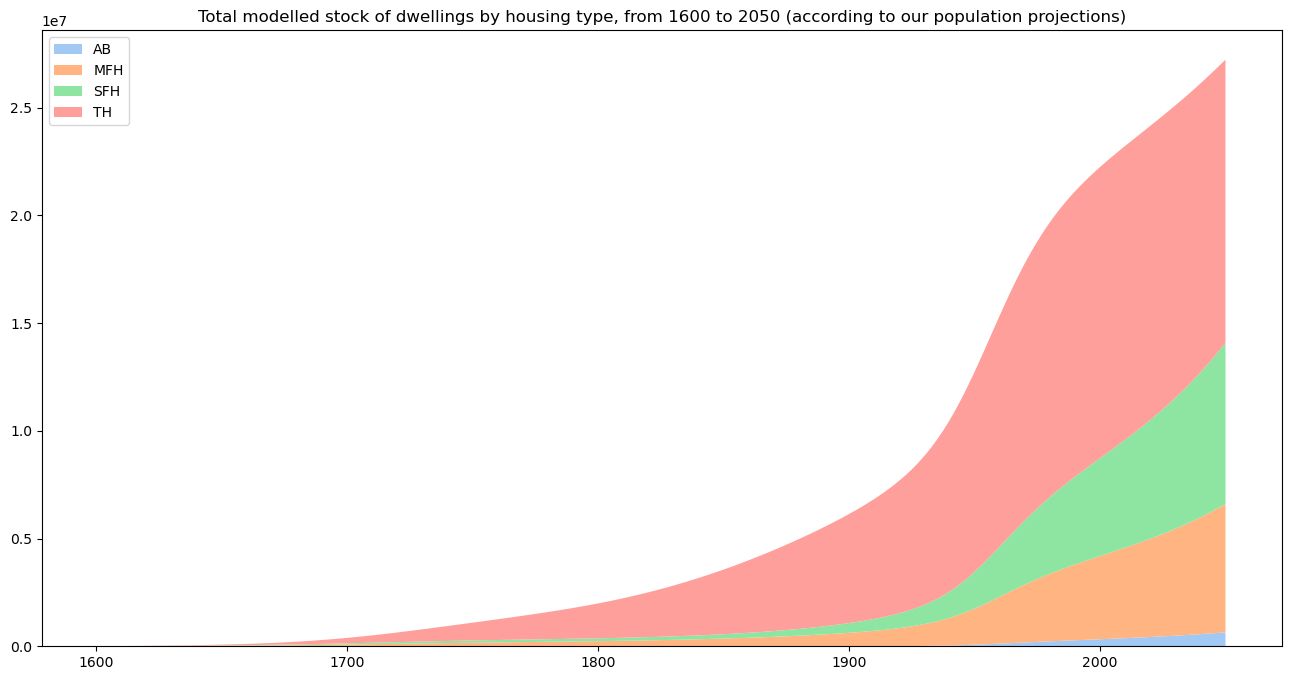

In [5]:
DSM_by_TYP = [dsm['Stock'].to_list() for dsm in DSM_all[1:]]
colors = sns.color_palette('pastel')[0:4]

plt.figure(figsize=(16,8))
plt.stackplot(DSM.index,DSM_by_TYP, labels=TYP[1:], colors=colors)
plt.legend(loc='upper left')
plt.title('Total modelled stock of dwellings by housing type, from 1600 to 2050 (according to our population projections)')
plt.show()

We kepp Population and PpD => We keep the stock

# Energy mix

In [6]:
file = "Model/FEC-energy-mix-bau.csv"

NRJ_FEC_bau = pd.read_csv(file)
NRJ_FEC_bau = NRJ_FEC_bau.set_index('Unnamed: 0')
NRJ_FEC_bau.index.name = None
display(NRJ_FEC_bau)

,Gas,Oil,Coal,Wood,LPG,Renewables
1600,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1601,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1602,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1603,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1604,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...
2046,0.878028,0.048255,0.010739,0.003043,0.007099,0.052837
2047,0.878028,0.048255,0.010739,0.003043,0.007099,0.052837
2048,0.878028,0.048255,0.010739,0.003043,0.007099,0.052837
2049,0.878028,0.048255,0.010739,0.003043,0.007099,0.052837


[]

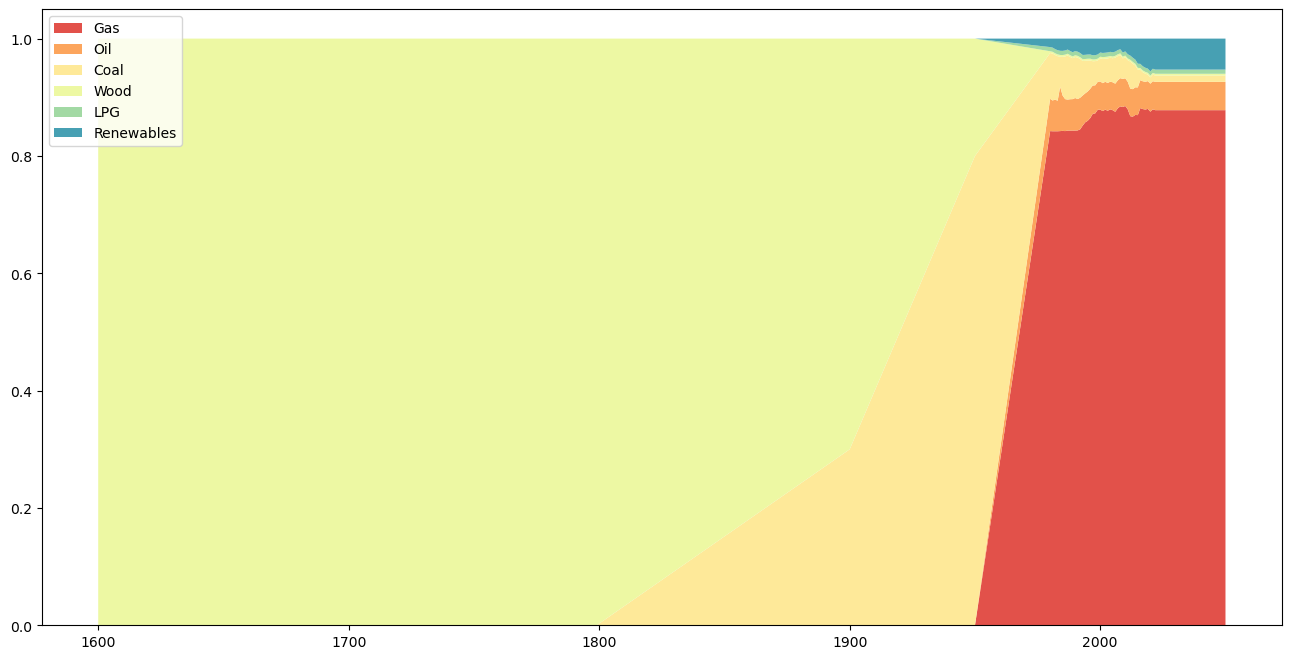

In [7]:
colors = sns.color_palette("Spectral")[0:7]

stack_NRJ_FEC_bau = [NRJ_FEC_bau[k].to_list() for k in NRJ_FEC_bau.columns]
lab = [str(k) for k in NRJ_FEC_bau.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_bau.index,stack_NRJ_FEC_bau, labels=lab, colors=colors)
plt.legend(loc='upper left')
#fig = ax.get_figure()
#fig.savefig("Output/Energy/fec-sources.png",dpi=300,bbox_inches="tight")
plt.plot()

,Gas,Oil,Coal,Wood,LPG,Renewables
2020,0.875466,0.047747,0.010787,0.003043,0.007099,0.055857
2021,0.879424,0.047953,0.011117,0.003043,0.007099,0.051364
2022,0.878028,0.048255,0.010739,0.003043,0.007099,0.052837
2023,0.873821,0.048024,0.010687,0.003028,0.007917,0.056523
2024,0.869556,0.047789,0.010635,0.003013,0.008746,0.060261
2025,0.865231,0.047552,0.010582,0.002998,0.009586,0.064050
2026,0.860847,0.047311,0.010529,0.002983,0.010438,0.067893
2027,0.856401,0.047066,0.010474,0.002968,0.011302,0.071789
2028,0.851891,0.046818,0.010419,0.002952,0.012179,0.075741
2029,0.847318,0.046567,0.010363,0.002936,0.013067,0.079749


,Gas,Oil,Coal,Wood,LPG,Renewables
2040,0.659599,0.036250,0.008067,0.002286,0.017255,0.276543
2041,0.641529,0.035257,0.007846,0.002223,0.017579,0.295565
2042,0.623501,0.034266,0.007626,0.002161,0.017903,0.314543
2043,0.605516,0.033278,0.007406,0.002098,0.018226,0.333476
2044,0.587573,0.032292,0.007186,0.002036,0.018548,0.352365
2045,0.569673,0.031308,0.006967,0.001974,0.018869,0.371209
2046,0.551814,0.030327,0.006749,0.001912,0.019189,0.390009
2047,0.533997,0.029348,0.006531,0.001850,0.019509,0.408764
2048,0.516222,0.028371,0.006314,0.001789,0.019828,0.427476
2049,0.498489,0.027396,0.006097,0.001727,0.020147,0.446145


[]

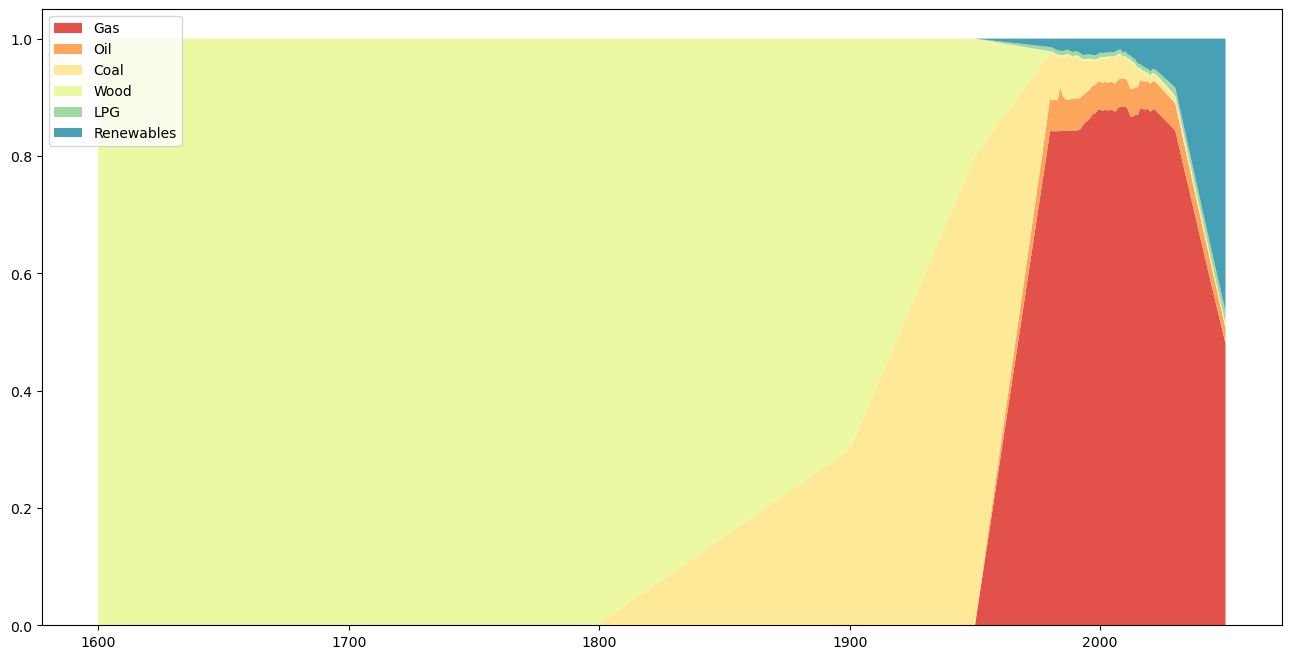

In [8]:
NRJ_FEC_half = NRJ_FEC_bau.copy(deep=True)
for i in np.arange(2023,2051):
    NRJ_FEC_half.loc[i,:] =  [None for j in np.arange(len(NRJ_FEC_half.columns))]
# 2030: Renewable capacity x3
NRJ_FEC_half.loc[2030,'Renewables'] = 1.5*NRJ_FEC_half.loc[2022,'Renewables']
# LPG is our own assumption 
NRJ_FEC_half.loc[2030,'LPG'] = NRJ_FEC_half.loc[2030,'Renewables']/6
rest_2030 = 1-NRJ_FEC_half.loc[2030,'LPG']-NRJ_FEC_half.loc[2030,'Renewables']
# For the rest, we keep the same relative shares as in bau 
for j in NRJ_FEC_half.columns[:4]:
    part = NRJ_FEC_bau.loc[2030,j]/NRJ_FEC_bau.loc[2030,'Gas':'Wood'].sum()
    NRJ_FEC_half.loc[2030,j] = NRJ_FEC_bau.loc[2030,j]*rest_2030
# 2050: Nuclear capacity doubles
# => We do not consider any nuclear power in the UK case as nothing is done yet (only in imports eventually)
# 2050: Renewable capacity = 90%
NRJ_FEC_half.loc[2050,'Renewables'] = 0.45
NRJ_FEC_half.loc[2050,'LPG'] = NRJ_FEC_half.loc[2030,'LPG']*1.5
rest_2050 = 1-NRJ_FEC_half.loc[2050,'LPG']-NRJ_FEC_half.loc[2050,'Renewables']
for j in NRJ_FEC_half.columns[:4]:
    part = NRJ_FEC_bau.loc[2050,j]/NRJ_FEC_bau.loc[2050,'Gas':'Wood'].sum()
    NRJ_FEC_half.loc[2050,j] = NRJ_FEC_bau.loc[2050,j]*rest_2050
# Interpolation 
NRJ_FEC_half.interpolate(method='linear',inplace=True)
# Force the total share of 1 
for i in NRJ_FEC_half.index:
    share = NRJ_FEC_half.loc[i,:].sum()
    for j in NRJ_FEC_half.columns:
        NRJ_FEC_half.loc[i,j] = NRJ_FEC_half.loc[i,j]/share 

display(NRJ_FEC_half.loc[2020:2030,:])
display(NRJ_FEC_half.loc[2040:2050,:])


stack_NRJ_FEC_iea = [NRJ_FEC_half[k].to_list() for k in NRJ_FEC_half.columns]
lab = [str(k) for k in NRJ_FEC_half.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_half.index,stack_NRJ_FEC_iea, labels=lab, colors=colors)
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-half-net-zero.png",dpi=300,bbox_inches="tight")
plt.plot()

,Gas,Oil,Coal,Wood,LPG,Renewables
2020,0.875466,0.047747,0.010787,0.003043,0.007099,0.055857
2021,0.879424,0.047953,0.011117,0.003043,0.007099,0.051364
2022,0.878028,0.048255,0.010739,0.003043,0.007099,0.052837
2023,0.859912,0.047259,0.010517,0.002980,0.012893,0.066439
2024,0.841580,0.046252,0.010293,0.002916,0.018755,0.080203
2025,0.823028,0.045232,0.010066,0.002852,0.024689,0.094133
2026,0.804251,0.044200,0.009837,0.002787,0.030694,0.108232
2027,0.785246,0.043156,0.009604,0.002721,0.036772,0.122502
2028,0.766007,0.042098,0.009369,0.002654,0.042924,0.136947
2029,0.746532,0.041028,0.009131,0.002587,0.049153,0.151570


,Gas,Oil,Coal,Wood,LPG,Renewables
2040,0.364170,0.020014,0.004454,0.001262,0.067688,0.542412
2041,0.328844,0.018073,0.004022,0.001140,0.068879,0.579042
2042,0.293684,0.016140,0.003592,0.001018,0.070065,0.615501
2043,0.258689,0.014217,0.003164,0.000896,0.071245,0.651789
2044,0.223857,0.012303,0.002738,0.000776,0.072420,0.687907
2045,0.189188,0.010397,0.002314,0.000656,0.073589,0.723857
2046,0.154679,0.008501,0.001892,0.000536,0.074753,0.759639
2047,0.120331,0.006613,0.001472,0.000417,0.075911,0.795256
2048,0.086142,0.004734,0.001054,0.000299,0.077064,0.830707
2049,0.052111,0.002864,0.000637,0.000181,0.078212,0.865995


[]

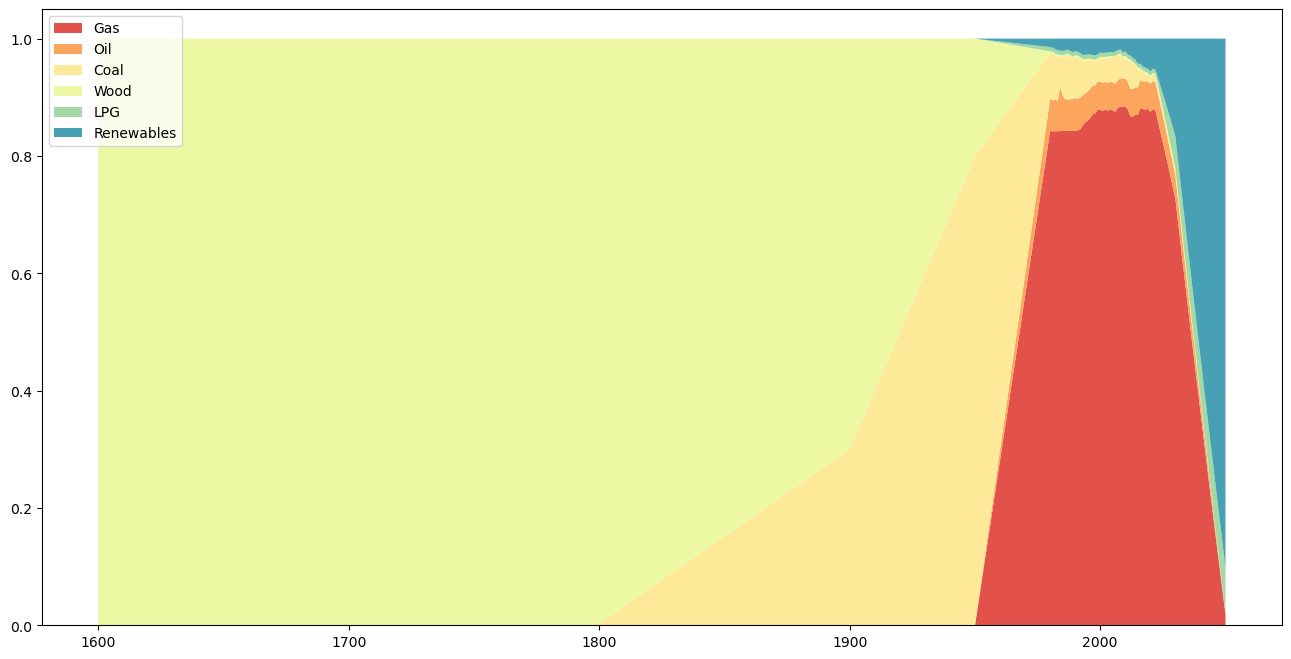

In [9]:
NRJ_FEC_iea = NRJ_FEC_bau.copy(deep=True)
for i in np.arange(2023,2051):
    NRJ_FEC_iea.loc[i,:] =  [None for j in np.arange(len(NRJ_FEC_iea.columns))]
# 2030: Renewable capacity x3
NRJ_FEC_iea.loc[2030,'Renewables'] = 3*NRJ_FEC_iea.loc[2022,'Renewables']
# LPG is our own assumption 
NRJ_FEC_iea.loc[2030,'LPG'] = NRJ_FEC_iea.loc[2030,'Renewables']/3
rest_2030 = 1-NRJ_FEC_iea.loc[2030,'LPG']-NRJ_FEC_iea.loc[2030,'Renewables']
# For the rest, we keep the same relative shares as in bau 
for j in NRJ_FEC_iea.columns[:4]:
    part = NRJ_FEC_bau.loc[2030,j]/NRJ_FEC_bau.loc[2030,'Gas':'Wood'].sum()
    NRJ_FEC_iea.loc[2030,j] = NRJ_FEC_bau.loc[2030,j]*rest_2030
# 2050: Nuclear capacity doubles
# => We do not consider any nuclear power in the UK case as nothing is done yet (only in imports eventually)
# 2050: Renewable capacity = 90%
NRJ_FEC_iea.loc[2050,'Renewables'] = 0.9
NRJ_FEC_iea.loc[2050,'LPG'] = NRJ_FEC_iea.loc[2030,'LPG']*1.5
rest_2050 = 1-NRJ_FEC_iea.loc[2050,'LPG']-NRJ_FEC_iea.loc[2050,'Renewables']
for j in NRJ_FEC_iea.columns[:4]:
    part = NRJ_FEC_bau.loc[2050,j]/NRJ_FEC_bau.loc[2050,'Gas':'Wood'].sum()
    NRJ_FEC_iea.loc[2050,j] = NRJ_FEC_bau.loc[2050,j]*rest_2050
# Interpolation 
NRJ_FEC_iea.interpolate(method='linear',inplace=True)
# Force the total share of 1 
for i in NRJ_FEC_iea.index:
    share = NRJ_FEC_iea.loc[i,:].sum()
    for j in NRJ_FEC_iea.columns:
        NRJ_FEC_iea.loc[i,j] = NRJ_FEC_iea.loc[i,j]/share 

display(NRJ_FEC_iea.loc[2020:2030,:])
display(NRJ_FEC_iea.loc[2040:2050,:])

"""
test = True
for i in NRJ_FEC_iea.index:
    if NRJ_FEC_iea.loc[i,:].sum() != 1.0:
        print(i)
        print(NRJ_FEC_iea.loc[i,:].sum())
        test = False
print(test)
"""

stack_NRJ_FEC_iea = [NRJ_FEC_iea[k].to_list() for k in NRJ_FEC_iea.columns]
lab = [str(k) for k in NRJ_FEC_iea.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_iea.index,stack_NRJ_FEC_iea, labels=lab, colors=colors)
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-net-zero.png",dpi=300,bbox_inches="tight")
plt.plot()

We have three energy mix paths here: 
* `NRJ_FEC_bau` is considering that we keep the same energy mix from now on, until 2050 (no efforts are done, it is our worst scenario and most likely not to happen)
* `NRJ_FEC_iea` is considering IEA's recommandations for the energy mix (2030 and 2050 targets)
* `NRJ_FEC_helf`is built as a 'halfway' scenario between `NRJ_FEC_bau` and `NRJ_FEC_iea`

In [27]:
NRJ_EFF = pd.DataFrame(index=np.arange(1600,2051),columns = NRJ_FEC_iea.columns).astype('float')
NRJ_EFF.index.name = 'Time'
for i in NRJ_EFF.index:
    NRJ_EFF.loc[i,'Gas'] = 0.95 # efficiency
    # TBD GAS 70 BEFORE ??? 
    NRJ_EFF.loc[i,'Oil'] = 0.85 
    NRJ_EFF.loc[i,'Coal'] = 0.70 
    NRJ_EFF.loc[i,'Wood'] = 0.80 
    NRJ_EFF.loc[i,'LPG'] = 0.95 
    NRJ_EFF.loc[i,'Renewables'] = 0.60
display(NRJ_EFF)

,Gas,Oil,Coal,Wood,LPG,Renewables
Time,,,,,,
1600,0.95,0.85,0.7,0.8,0.95,0.6
1601,0.95,0.85,0.7,0.8,0.95,0.6
1602,0.95,0.85,0.7,0.8,0.95,0.6
1603,0.95,0.85,0.7,0.8,0.95,0.6
1604,0.95,0.85,0.7,0.8,0.95,0.6
...,...,...,...,...,...,...
2046,0.95,0.85,0.7,0.8,0.95,0.6
2047,0.95,0.85,0.7,0.8,0.95,0.6
2048,0.95,0.85,0.7,0.8,0.95,0.6


In [28]:
def mean_energy(col,fec,raw):
    mean_table = pd.DataFrame(index=np.arange(1600,2051),columns = [col]).astype('float')
    mean_table.index.name = 'Time'
    for i in mean_table.index:
        mean_table.loc[i,col] = fec.loc[i,'Gas']*raw.loc[i,'Gas'] + fec.loc[i,'Oil']*raw.loc[i,'Oil'] + fec.loc[i,'Coal']*raw.loc[i,'Coal'] + fec.loc[i,'Wood']*raw.loc[i,'Wood'] + fec.loc[i,'LPG']*raw.loc[i,'LPG'] + fec.loc[i,'Renewables']*raw.loc[i,'Renewables']
    return mean_table

NRJ_EFF_iea = mean_energy('Efficiency',NRJ_FEC_iea,NRJ_EFF)
display(NRJ_EFF_iea)

NRJ_EFF_half = mean_energy('Efficiency',NRJ_FEC_half,NRJ_EFF)
display(NRJ_EFF_half)

NRJ_EFF_bau = mean_energy('Efficiency',NRJ_FEC_bau,NRJ_EFF)
display(NRJ_EFF_bau)

,Efficiency
Time,
1600,0.800000
1601,0.800000
1602,0.800000
1603,0.800000
1604,0.800000
...,...
2046,0.682723
2047,0.670569
2048,0.658471


,Efficiency
Time,
1600,0.800000
1601,0.800000
1602,0.800000
1603,0.800000
1604,0.800000
...,...
2046,0.808490
2047,0.802087
2048,0.795699


,Efficiency
Time,
1600,0.800000
1601,0.800000
1602,0.800000
1603,0.800000
1604,0.800000
...,...
2046,0.923541
2047,0.923541
2048,0.923541


In [65]:
def kgCO2_kWh_to_tCO2e_ktoe(NRJ_CO2_MEAN):
    NRJ_CO2_MEAN = NRJ_CO2_MEAN*1000
    print('The average CO2e emissions of the UK/England heating energy is of about : ', NRJ_CO2_MEAN['Emissions'].mean(),' kCO2e/MWh')
    NRJ_CO2_MEAN = NRJ_CO2_MEAN*11.63/1000
    print('The average CO2e emissions of the UK/England heating energy is of about : ', NRJ_CO2_MEAN['Emissions'].mean(),' tCO2e/toe')
    NRJ_CO2_MEAN = NRJ_CO2_MEAN*1000
    print('The average CO2e emissions of the UK/England heating energy is of about : ', NRJ_CO2_MEAN['Emissions'].mean(),' tCO2e/ktoe')
    return NRJ_CO2_MEAN

,Gas,Oil,Coal,Wood,LPG,Renewables
Time,,,,,,
1600,0.185,0.255,0.4075,0.025,0.22,0.03
1601,0.185,0.255,0.4075,0.025,0.22,0.03
1602,0.185,0.255,0.4075,0.025,0.22,0.03
1603,0.185,0.255,0.4075,0.025,0.22,0.03
1604,0.185,0.255,0.4075,0.025,0.22,0.03
...,...,...,...,...,...,...
2046,0.185,0.255,0.4075,0.025,0.22,0.03
2047,0.185,0.255,0.4075,0.025,0.22,0.03
2048,0.185,0.255,0.4075,0.025,0.22,0.03


The average CO2e emissions of the UK/England heating energy is of about :  99.30842815201204  kCO2e/MWh
The average CO2e emissions of the UK/England heating energy is of about :  1.1549570194079004  tCO2e/toe
The average CO2e emissions of the UK/England heating energy is of about :  1154.9570194079001  tCO2e/ktoe


,Emissions
Time,
1600,290.750000
1601,290.750000
1602,290.750000
1603,290.750000
1604,290.750000
...,...
2046,823.433172
2047,757.298184
2048,691.469375


The average CO2e emissions of the UK/England heating energy is of about :  101.30221893736504  kCO2e/MWh
The average CO2e emissions of the UK/England heating energy is of about :  1.1781448062415558  tCO2e/toe
The average CO2e emissions of the UK/England heating energy is of about :  1178.1448062415557  tCO2e/ktoe


,Emissions
Time,
1600,290.750000
1601,290.750000
1602,290.750000
1603,290.750000
1604,290.750000
...,...
2046,1494.907156
2047,1459.980959
2048,1425.136537


The average CO2e emissions of the UK/England heating energy is of about :  102.99150178266055  kCO2e/MWh
The average CO2e emissions of the UK/England heating energy is of about :  1.1977911657323423  tCO2e/toe
The average CO2e emissions of the UK/England heating energy is of about :  1197.7911657323423  tCO2e/ktoe


,Emissions
Time,
1600,290.750000
1601,290.750000
1602,290.750000
1603,290.750000
1604,290.750000
...,...
2046,2120.604816
2047,2120.604816
2048,2120.604816


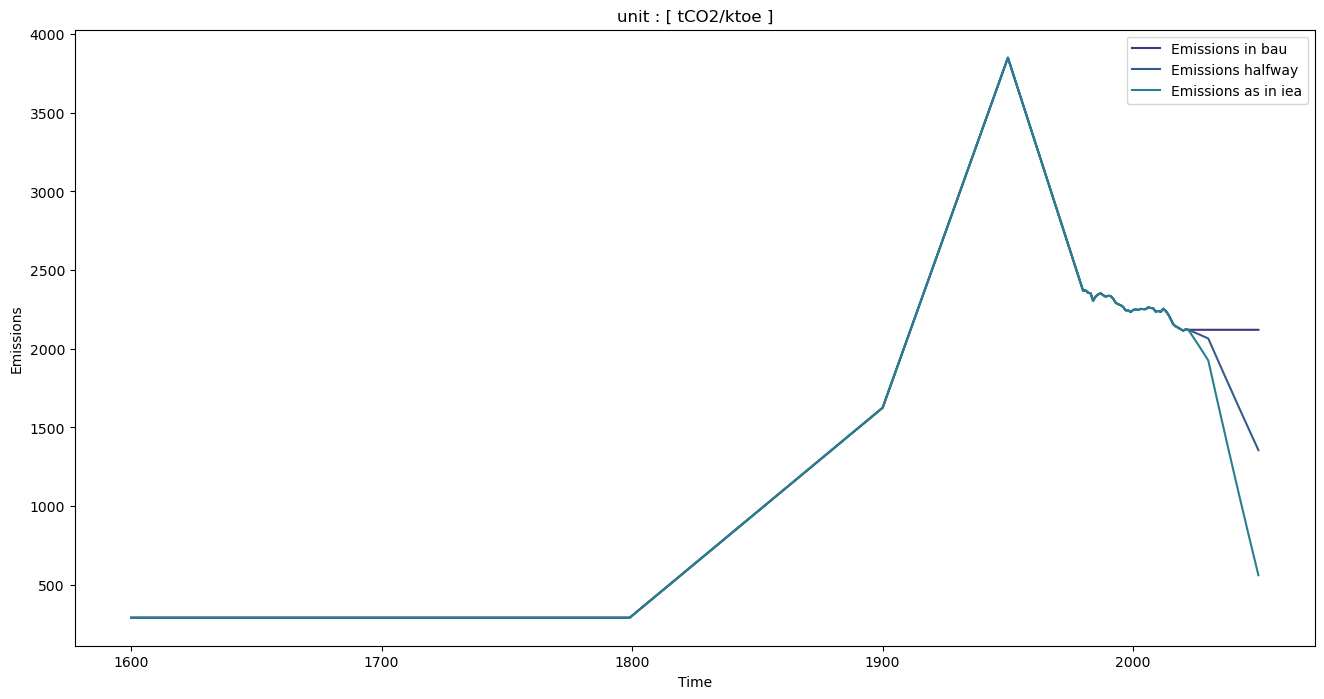

In [72]:
# Source : https://www.carbonindependent.org/15.html
# The average UK annual gas consumption is 16,000 kWh per household

# Source : https://www.euronuclear.org/glossary/fuel-comparison/#:~:text=8%20kWh%20of%20heat%20can,1%20kg%20of%20uranium%2D235.

# Hypothesis: same emissions throught time 

NRJ_CO2 = pd.DataFrame(index=np.arange(1600,2051),columns = NRJ_FEC_iea.columns).astype('float')
NRJ_CO2.index.name = 'Time'
for i in NRJ_CO2.index:
    NRJ_CO2.loc[i,'Gas'] = 0.185 # kgCO2/kWh
    NRJ_CO2.loc[i,'Oil'] = 0.255 # kgCO2/kWh
    # 3.26 kg CO2 per kg of coal & 8 kWh of heat can be generated from 1 kg of coal
    NRJ_CO2.loc[i,'Coal'] = 3.26/8 # kgCO2/kWh
    # 0.10 kg CO2 per kg of wood & 4 kWh of heat can be generated from 1 kg of wood
    NRJ_CO2.loc[i,'Wood'] = 0.10/4 # kgCO2/kWh
    NRJ_CO2.loc[i,'LPG'] = 0.220 # kgCO2/kWh
    NRJ_CO2.loc[i,'Renewables'] = 0.030 # kgCO2/kWh

display(NRJ_CO2)

NRJ_CO2_iea = mean_energy('Emissions',NRJ_FEC_iea,NRJ_CO2) # EMISSIONS NOT EFFICIENCY 
NRJ_CO2_iea = kgCO2_kWh_to_tCO2e_ktoe(NRJ_CO2_iea)
display(NRJ_CO2_iea)

NRJ_CO2_half = mean_energy('Emissions',NRJ_FEC_half,NRJ_CO2) # EMISSIONS NOT EFFICIENCY 
NRJ_CO2_half = kgCO2_kWh_to_tCO2e_ktoe(NRJ_CO2_half)
display(NRJ_CO2_half)

NRJ_CO2_bau = mean_energy('Emissions',NRJ_FEC_bau,NRJ_CO2) # EMISSIONS NOT EFFICIENCY 
NRJ_CO2_bau = kgCO2_kWh_to_tCO2e_ktoe(NRJ_CO2_bau)
display(NRJ_CO2_bau)

colors = sns.color_palette("viridis")[0:3]

ax = plt.figure(figsize=(16,8))
sns.lineplot(data=NRJ_CO2_bau,x=NRJ_CO2_bau.index,y="Emissions",label="Emissions in bau",color=colors[0])
sns.lineplot(data=NRJ_CO2_half,x=NRJ_CO2_bau.index,y="Emissions",label="Emissions halfway",color=colors[1])
sns.lineplot(data=NRJ_CO2_iea,x=NRJ_CO2_bau.index,y="Emissions",label="Emissions as in iea",color=colors[2])
plt.legend()
plt.title('unit : [ tCO2/ktoe ]')
plt.savefig("Output/Energy/CO2-intensity-per-ktoe.png",dpi=300,bbox_inches='tight')
plt.show()

# Renovation pace

In [10]:
file = "Model/Renovation.csv"
renovation_share_time = pd.read_csv(file)
renovation_share_time = renovation_share_time.set_index('Unnamed: 0')
renovation_share_time.index.name = None

"""
old_share_Amb_Rfb = 0.2
old_share_Std_Rfb = 1-old_share_Amb_Rfb

new_share_Amb_Rfb = 0.5
new_share_Std_Rfb = 1-new_share_Amb_Rfb

# We strongly increase the renovations rates for our NET ZERO targets
for i in np.arange(2010,2051):
    renovation_share_time.loc[i,:] = [None,None,None]
renovation_share_time.loc[2050,'TOT_Rfb'] = 0.06
renovation_share_time.loc[2050,'incl. Std_Rfb'] = renovation_share_time.loc[2050,'TOT_Rfb']*new_share_Std_Rfb
renovation_share_time.loc[2050,'incl. Amb_Rfb'] = renovation_share_time.loc[2050,'TOT_Rfb']*new_share_Amb_Rfb
renovation_share_time.interpolate(method='linear',inplace=True)
"""

display(renovation_share_time)

,TOT_Rfb,incl. Std_Rfb,incl. Amb_Rfb
1600,0.00,0.000,0.000
1601,0.00,0.000,0.000
1602,0.00,0.000,0.000
1603,0.00,0.000,0.000
1604,0.00,0.000,0.000
...,...,...,...
2046,0.03,0.024,0.006
2047,0.03,0.024,0.006
2048,0.03,0.024,0.006
2049,0.03,0.024,0.006


,TOT_Rfb,incl. Std_Rfb,incl. Amb_Rfb
1600,NaN,NaN,NaN
1601,0.000000,0.000000,0.000000
1602,0.000000,0.000000,0.000000
1603,0.000000,0.000000,0.000000
1604,0.000000,0.000000,0.000000
...,...,...,...
2046,803454.057646,642763.246117,160690.811529
2047,806824.784502,645459.827601,161364.956900
2048,810223.374474,648178.699580,162044.674895
2049,813649.793778,650919.835023,162729.958756


[]

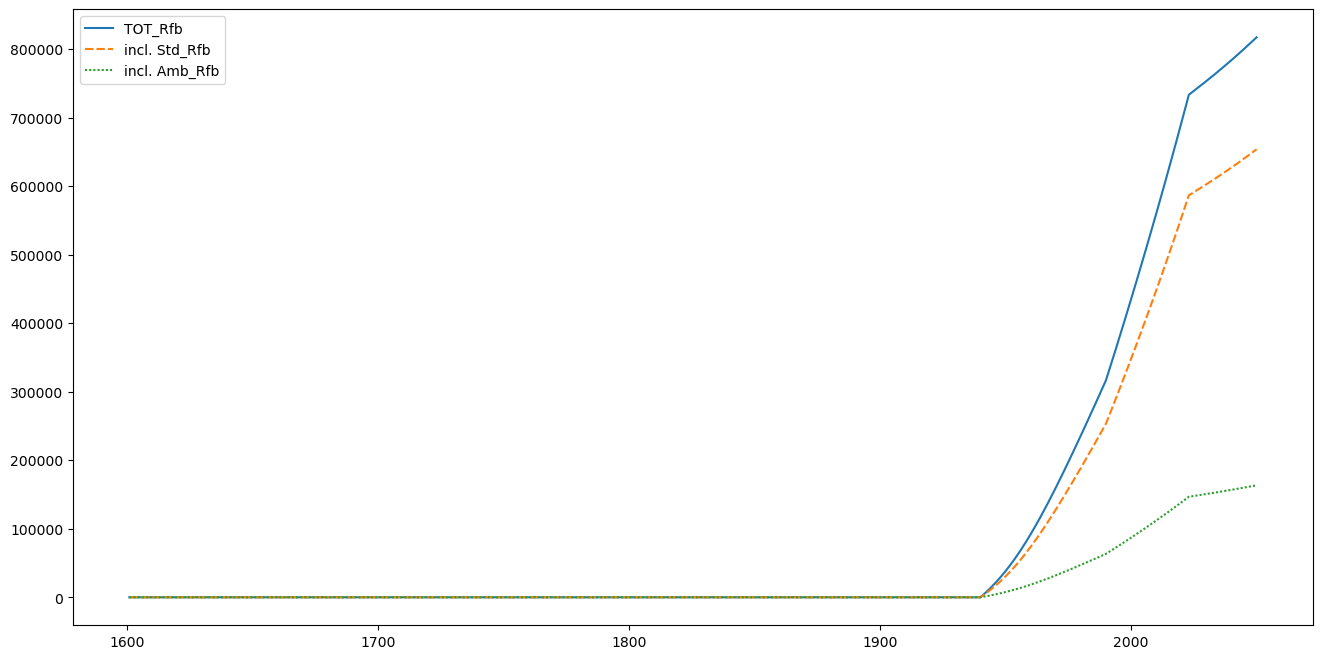

In [11]:
def renovation(renovation_share,dystomod):
    renovation_time = renovation_share.copy(deep=True)
    for i in renovation_time.index:
        for j in renovation_time.columns:
            renovation_time.loc[i,j] = renovation_share.loc[i,j]*dystomod.loc[i,'Stock']
    return renovation_time

renovation_time = renovation(renovation_share_time,DSM)

display(renovation_time)
ax = plt.figure(figsize=(16,8))
sns.lineplot(data=renovation_time)
plt.plot()

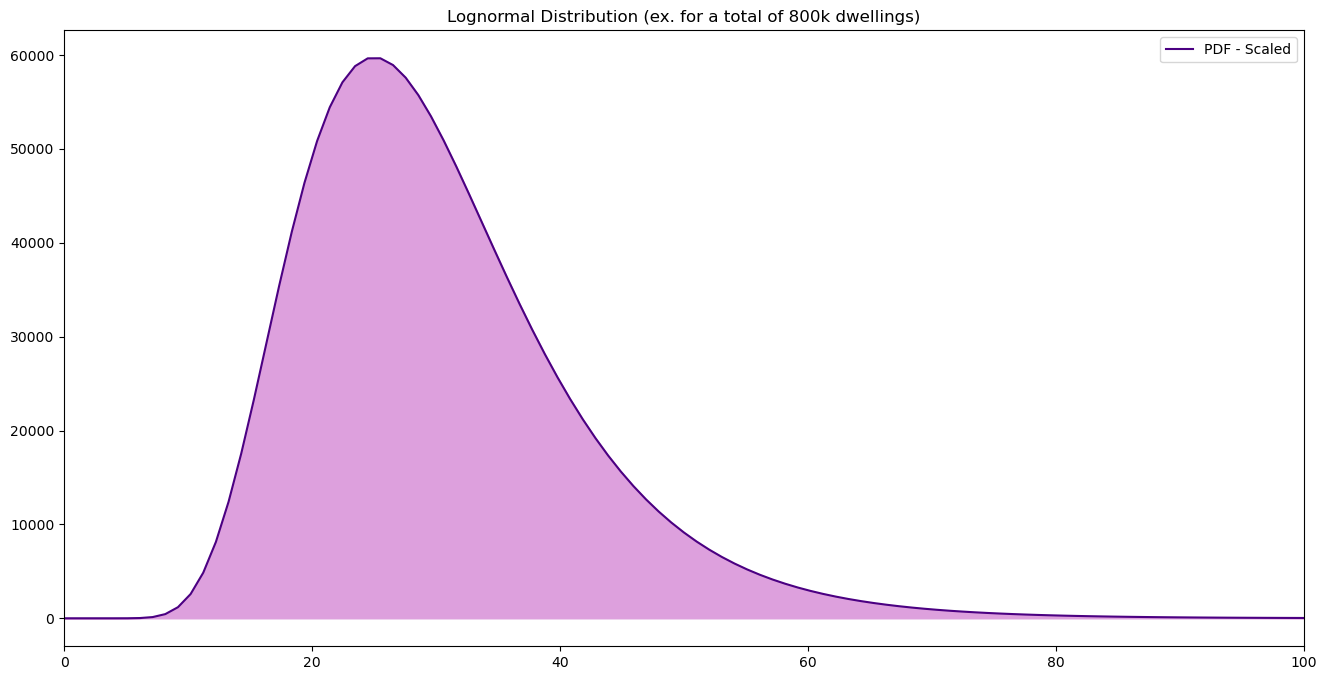

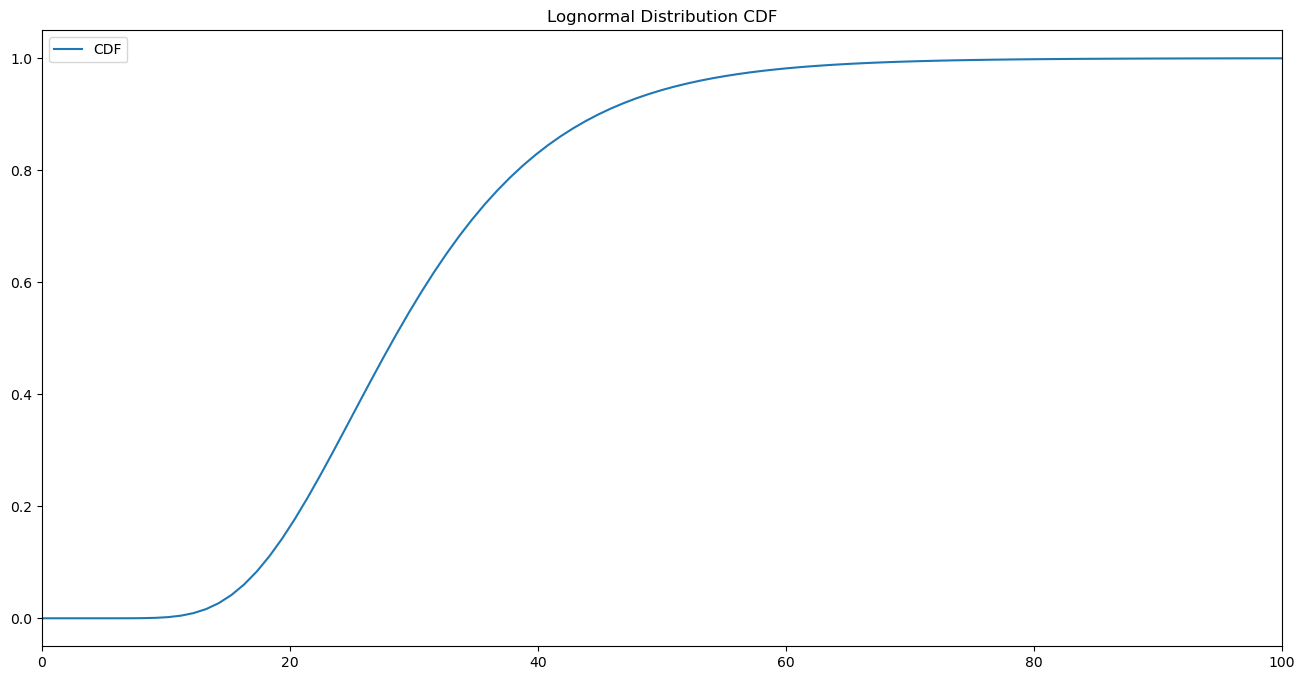

In [12]:
mode = 25
begin_increase = 22
end_decrease = 30
total = 800000

def Std_Rfb_distribution(number,mode=mode,begin_increase=begin_increase,end_decrease=end_decrease):
    # Use mode to estimate sigma considering the increase and decrease intervals
    # Since mode = exp(mu - sigma^2), solve for mu and sigma
    sigma = np.sqrt(np.log(mode / begin_increase))
    mu = np.log(mode) + sigma**2
    # Create a lognormal distribution
    dist = stats.lognorm(s=sigma, scale=np.exp(mu))
    # Generate values
    x = np.linspace(0, 101, 100)
    pdf_values = dist.pdf(x)
    cdf_values = dist.cdf(x)
    # Scale PDF to match the total cumulative distribution
    pdf_scaled = pdf_values * (number / dist.cdf(end_decrease))
    return x,pdf_values,pdf_scaled,cdf_values

x,pdf_values,pdf_scaled,cdf_values = Std_Rfb_distribution(total)

# Visualization
ax = plt.figure(figsize=(16, 8))
plt.plot(x, pdf_scaled, label='PDF - Scaled',color='indigo')
plt.fill_between(x, pdf_scaled, color='plum')
plt.title('Lognormal Distribution (ex. for a total of 800k dwellings)')
plt.xlim(0, 100)
plt.legend()
fig = ax.get_figure()
fig.savefig("Output/Energy/renovation_model.png",dpi=300,bbox_inches="tight")
plt.show()

ax = plt.figure(figsize=(16, 8))
plt.plot(x, cdf_values, label='CDF')
plt.title('Lognormal Distribution CDF')
plt.xlim(0, 100)
plt.legend()
plt.show()

In [13]:
print(renovation_share_time.index)
renovation_numbers = renovation(renovation_share_time,DSM)
display(renovation_numbers)
number_Std_Rfb = renovation_numbers.loc[1601,'incl. Std_Rfb']
print(number_Std_Rfb)

#display(cohort_AB)

def refurbishment_on_cohorts(cohort,renovation_share,dystomod):
    cohort_AsBuilt = cohort.copy(deep=True)
    cohort_StdRfb = cohort.copy(deep=True)
    for col in cohort_StdRfb.columns:
        cohort_StdRfb[col].values[:] = 0
    cohort_AmbRfb = cohort.copy(deep=True)
    for col in cohort_AmbRfb.columns:
        cohort_AmbRfb[col].values[:] = 0
    renovation_numbers = renovation(renovation_share,dystomod)
    for c in cohort.columns[1:]: # FROM 1+ HERE BECAUSE 1600 NaN
        #share_Std_Rfb = renovation_share.loc[c,'incl. Std_Rfb']
        #share_Amb_Rfb = renovation_share.loc[c,'incl. Amb_Rfb']
        number_Std_Rfb = renovation_numbers.loc[c,'incl. Std_Rfb']
        number_Amb_Rfb = renovation_numbers.loc[c,'incl. Amb_Rfb']
        #print('Std and Amb rfb shares : ',share_Std_Rfb,share_Amb_Rfb)
        #print('Std and Amb rfb numbers : ',number_Std_Rfb,number_Amb_Rfb)
        x_Std,pdf_values_Std,pdf_scaled_Std,cdf_values_Std = Std_Rfb_distribution(number_Std_Rfb)
        x_Amb,pdf_values_Amb,pdf_scaled_Amb,cdf_values_Amb = Std_Rfb_distribution(number_Amb_Rfb)
        cumulated_Std = 0 
        cumulated_Amb = 0 
        bout = c
        for n in np.arange(1,len(pdf_scaled_Std)):
            bout = c+n
            if bout < 2051:
                new_Std = pdf_scaled_Std[n]
                cumulated_Std += new_Std
                new_Amb = pdf_scaled_Amb[n]
                cumulated_Amb += new_Amb
                cohort_AsBuilt.loc[c+n,c] = cohort.loc[c+n,c] - (cumulated_Std+cumulated_Amb)
                cohort_StdRfb.loc[c+n,c] = cumulated_Std
                cohort_AmbRfb.loc[c+n,c] = cumulated_Amb
        while bout < 2051:
            cohort_AsBuilt.loc[bout,c] = cohort.loc[bout,c] - (cumulated_Std+cumulated_Amb)
            cohort_StdRfb.loc[bout,c] = cumulated_Std
            cohort_AmbRfb.loc[bout,c] = cumulated_Amb
            bout += 1
    return cohort_AsBuilt,cohort_StdRfb,cohort_AmbRfb

cohort_AsBuilt_AB,cohort_StdRfb_AB,cohort_AmbRfb_AB = refurbishment_on_cohorts(cohort_AB,renovation_share_time,DSM_AB)

#display(cohort_AB)
#display(cohort_AsBuilt_AB)
#display(cohort_StdRfb_AB)
#display(cohort_AmbRfb_AB)

cohort_AB_state = [cohort_AsBuilt_AB,cohort_StdRfb_AB,cohort_AmbRfb_AB]

cohort_AsBuilt_MFH,cohort_StdRfb_MFH,cohort_AmbRfb_MFH = refurbishment_on_cohorts(cohort_MFH,renovation_share_time,DSM_MFH)

#display(cohort_MFH)
#display(cohort_AsBuilt_MFH)
#display(cohort_StdRfb_MFH)
#display(cohort_AmbRfb_MFH)

cohort_MFH_state = [cohort_AsBuilt_MFH,cohort_StdRfb_MFH,cohort_AmbRfb_MFH]

cohort_AsBuilt_SFH,cohort_StdRfb_SFH,cohort_AmbRfb_SFH = refurbishment_on_cohorts(cohort_SFH,renovation_share_time,DSM_SFH)

#display(cohort_SFH)
#display(cohort_AsBuilt_SFH)
#display(cohort_StdRfb_SFH)
#display(cohort_AmbRfb_SFH)

cohort_SFH_state = [cohort_AsBuilt_SFH,cohort_StdRfb_SFH,cohort_AmbRfb_SFH]

cohort_AsBuilt_TH,cohort_StdRfb_TH,cohort_AmbRfb_TH = refurbishment_on_cohorts(cohort_TH,renovation_share_time,DSM_TH)

#display(cohort_TH)
#display(cohort_AsBuilt_TH)
#display(cohort_StdRfb_TH)
#display(cohort_AmbRfb_TH)

cohort_TH_state = [cohort_AsBuilt_TH,cohort_StdRfb_TH,cohort_AmbRfb_TH]

cohort_all_states = [cohort_AB_state,cohort_MFH_state,cohort_SFH_state,cohort_TH_state]

Int64Index([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609,
            ...
            2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050],
           dtype='int64', length=451)


,TOT_Rfb,incl. Std_Rfb,incl. Amb_Rfb
1600,NaN,NaN,NaN
1601,0.000000,0.000000,0.000000
1602,0.000000,0.000000,0.000000
1603,0.000000,0.000000,0.000000
1604,0.000000,0.000000,0.000000
...,...,...,...
2046,803454.057646,642763.246117,160690.811529
2047,806824.784502,645459.827601,161364.956900
2048,810223.374474,648178.699580,162044.674895
2049,813649.793778,650919.835023,162729.958756


0.0


In [19]:
display(cohort_AB)
display(cohort_AsBuilt_AB+cohort_StdRfb_AB+cohort_AmbRfb_AB)
display(((cohort_StdRfb_AB+cohort_AmbRfb_AB)/cohort_AB).loc[2020:2030,1995:2005])

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
1600,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,0,0,0,0,0,0,0,0,0,...,9717.521267,9897.761928,10080.250389,10264.999652,10452.022625,10674.089303,0.000000,0.000000,0.000000,0.000000
2047,0,0,0,0,0,0,0,0,0,0,...,9686.761541,9866.589253,10048.664169,10232.999374,10419.607862,10608.502531,10832.940856,0.000000,0.000000,0.000000
2048,0,0,0,0,0,0,0,0,0,0,...,9655.945658,9835.357669,10017.016233,10200.934519,10387.125606,10575.602478,10766.378023,10993.201521,0.000000,0.000000
2049,0,0,0,0,0,0,0,0,0,0,...,9625.075491,9804.069066,9985.308489,10168.807012,10354.577800,10542.633922,10732.988352,10925.653968,11154.876195,0.000000


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
1600,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,0,0,0,0,0,0,0,0,0,...,9717.521267,9897.761928,10080.250389,10264.999652,10452.022625,10674.089303,0.000000,0.000000,0.000000,0.000000
2047,0,0,0,0,0,0,0,0,0,0,...,9686.761541,9866.589253,10048.664169,10232.999374,10419.607862,10608.502531,10832.940856,0.000000,0.000000,0.000000
2048,0,0,0,0,0,0,0,0,0,0,...,9655.945658,9835.357669,10017.016233,10200.934519,10387.125606,10575.602478,10766.378023,10993.201521,0.000000,0.000000
2049,0,0,0,0,0,0,0,0,0,0,...,9625.075491,9804.069066,9985.308489,10168.807012,10354.577800,10542.633922,10732.988352,10925.653968,11154.876195,0.000000


,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005
2020,0.687442,0.636558,0.580345,0.519954,0.456790,0.392477,0.328793,0.267573,0.210597,0.159444,0.115359
2021,0.761992,0.714407,0.660562,0.601388,0.538086,0.472116,0.405152,0.339016,0.275585,0.216668,0.163871
2022,0.835414,0.791881,0.741346,0.684513,0.622360,0.556141,0.487363,0.417750,0.349168,0.283531,0.222684
2023,0.907063,0.868183,0.821742,0.768226,0.708385,0.643242,0.574101,0.502518,0.430259,0.359235,0.291403
2024,0.976420,0.942643,0.900921,0.851537,0.795017,0.732153,0.664016,0.591953,0.517565,0.442664,0.369208
2025,1.043083,1.014720,0.978188,0.933587,0.881233,0.821692,0.755798,0.684663,0.609678,0.532487,0.454954
2026,1.106759,1.083998,1.052984,1.013656,0.966145,0.910801,0.848229,0.779299,0.705164,0.627256,0.547271
2027,1.167252,1.150172,1.124874,1.091164,1.049006,0.998562,0.940215,0.874604,0.802634,0.725496,0.644671
2028,1.224450,1.213038,1.193543,1.165661,1.129217,1.084204,1.030810,0.969452,0.900793,0.825775,0.745638
2029,1.278313,1.272479,1.258780,1.236819,1.206312,1.167105,1.119217,1.062863,0.998480,0.926764,0.848701


We keep the same renovation rate as in our first scenario and model (business as usual). In fact, this will simplify our scenario, allowing us to focus on the impact of a changing energy mix. Moreover, changing the energy mix already implies that there is renovation of the heating systems in housings (rather than on the buildings hardware features such as the roof and the walls and insulation). This also takes into account a potential limited workforce. 

# Energy demand per dwelling

In [17]:
NRJ_AsBuilt_Dwe = pd.read_csv("Model/NRJ_AsBuilt_Dwe.csv")
NRJ_AsBuilt_Dwe = NRJ_AsBuilt_Dwe.set_index('cohort')

NRJ_StdRfb_Dwe = pd.read_csv("Model/NRJ_StdRfb_Dwe.csv")
NRJ_StdRfb_Dwe = NRJ_StdRfb_Dwe.set_index('cohort')

NRJ_AmbRfb_Dwe = pd.read_csv("Model/NRJ_AmbRfb_Dwe.csv")
NRJ_AmbRfb_Dwe = NRJ_AmbRfb_Dwe.set_index('cohort')

display(NRJ_AsBuilt_Dwe)
display(NRJ_StdRfb_Dwe)
display(NRJ_AmbRfb_Dwe)

,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,32.000141,26.229481,16.560984,49.799042,33.935441
1601,31.994503,26.223842,16.553119,49.797944,33.928380
1602,31.988979,26.218318,16.545413,49.796869,33.921461
1603,31.983569,26.212907,16.537865,49.795816,33.914685
1604,31.978273,26.207610,16.530477,49.794785,33.908052
...,...,...,...,...,...
2046,5.246611,2.716706,3.224506,9.911613,6.287985
2047,5.238785,2.710334,3.221102,9.906782,6.273146
2048,5.231641,2.704341,3.218040,9.902553,6.259656


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,10.520915,4.457547,6.581151,20.874597,13.000856
1601,10.519062,4.456589,6.578025,20.874137,12.998151
1602,10.517246,4.455650,6.574963,20.873686,12.995501
1603,10.515467,4.454730,6.571964,20.873244,12.992905
1604,10.513726,4.453830,6.569028,20.872812,12.990364
...,...,...,...,...,...
2046,5.246611,2.716706,3.224506,9.911613,6.287985
2047,5.238785,2.710334,3.221102,9.906782,6.273146
2048,5.231641,2.704341,3.218040,9.902553,6.259656


,TOT,AB,MFH,SFH,TH
cohort,,,,,
1600,8.387121,3.640378,5.001003,16.931855,10.427298
1601,8.385643,3.639596,4.998628,16.931482,10.425128
1602,8.384195,3.638829,4.996301,16.931116,10.423003
1603,8.382777,3.638078,4.994022,16.930758,10.420921
1604,8.381389,3.637343,4.991791,16.930407,10.418882
...,...,...,...,...,...
2046,5.244059,2.716706,3.224506,9.895471,6.287985
2047,5.237024,2.710334,3.221102,9.895642,6.273146
2048,5.230577,2.704341,3.218040,9.895823,6.259656


# ENERGY DEMAND

In [21]:
cohort_ED_AB = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_AB.index.name = 'time'
cohort_ED_MFH = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_MFH.index.name = 'time'
cohort_ED_SFH = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_SFH.index.name = 'time'
cohort_ED_TH = pd.DataFrame(index=np.arange(1600,2051),columns=np.arange(1600,2051))
cohort_ED_TH.index.name = 'time'
display(cohort_ED_AB)

cohort_ED_all = [cohort_ED_AB,cohort_ED_MFH,cohort_ED_SFH,cohort_ED_TH]
#print(TYP)

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
def fill_cohort_ED_to_zeros(cohort_ED):
    for c in cohort_ED.columns:
        for i in cohort_ED.index:
            cohort_ED.loc[i,c] = 0
    return cohort_ED

def fill_cohort_ED(k,cohort_TYP,NRJ_Dwe,cohort_ED):
    for c in cohort_TYP.columns:
        for i in cohort_TYP.index:
            cohort_ED.loc[i,c] += cohort_TYP.loc[i,c]*NRJ_Dwe.loc[c,k]
    return cohort_ED

In [25]:
NRJ_all_dwe = [NRJ_AsBuilt_Dwe,NRJ_StdRfb_Dwe,NRJ_AmbRfb_Dwe]

for t in np.arange(4):
    k = TYP[1+t]
    cohort_ED = cohort_ED_all[t]
    cohort_ED = fill_cohort_ED_to_zeros(cohort_ED)
    cohort_k = cohort_all_states[t]
    for s in np.arange(3):
        cohort_s = cohort_k[s]
        NRJ_s = NRJ_all_dwe[s]
        cohort_ED = fill_cohort_ED(k,cohort_s,NRJ_s,cohort_ED)
    cohort_ED_all[t] = cohort_ED

cohort_ED_AB = cohort_ED_all[0]
cohort_ED_MFH = cohort_ED_all[1]
cohort_ED_SFH = cohort_ED_all[2]
cohort_ED_TH = cohort_ED_all[3]

In [29]:
print('cohort_ED_SFH before in 100% AsBuilt was : 1505157')
display(cohort_ED_SFH)

cohort_ED_SFH before in 100% AsBuilt was : 1505157


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,0.0,14164.520813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,0.0,14077.487139,14358.751362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,0.0,14033.828756,14270.524241,14547.810999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,13990.079469,14226.267194,14458.422205,14731.747587,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,5505.984496,5581.696466,5655.409667,5727.142832,5796.914666,5864.743841,5930.649005,5994.648772,6056.761734,...,930059.743875,945197.876077,960610.50728,976291.045514,992233.667858,1011537.510217,0.0,0.0,0.0,0.0
2047,0.0,5505.781431,5581.485137,5655.18987,5726.91436,5796.677309,5864.497388,5930.393241,5994.38348,6056.486693,...,927115.673562,942220.99964,957600.457286,973247.539868,989156.462602,1005322.133985,1024885.313592,0.0,0.0,0.0
2048,0.0,5505.583644,5581.279287,5654.975758,5726.691784,5796.446063,5864.257265,5930.144029,5994.124968,6056.218664,...,924165.949548,939238.446016,954584.520572,970197.892096,986072.850096,1002204.337589,1018587.921994,1038406.452511,0.0,0.0


In [30]:
NRJ_Reno_Time = pd.DataFrame(index=NRJ_AsBuilt_Dwe.index,columns=NRJ_AsBuilt_Dwe.columns)
NRJ_Reno_Time.index.name = 'time'

In [31]:
for t in np.arange(4):
    k = TYP[1+t]
    cohort_ED = cohort_ED_all[t]
    display(cohort_ED)
    for i in NRJ_Reno_Time.index:
        total_ED_TYP = cohort_ED.loc[i,:].sum()
        NRJ_Reno_Time.loc[i,k] = total_ED_TYP
t = 'TOT'
for i in NRJ_Reno_Time.index:
    NRJ_Reno_Time.loc[i,t] = NRJ_Reno_Time.loc[i,'AB']+NRJ_Reno_Time.loc[i,'MFH']+NRJ_Reno_Time.loc[i,'SFH']+NRJ_Reno_Time.loc[i,'TH']

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26772.947905,27183.935812,27603.115457,28030.442585,28465.874588,28998.362155,0.0,0.0,0.0,0.0
2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26688.201134,27098.320902,27516.621765,27943.060026,28377.59363,28820.182178,29360.891122,0.0,0.0,0.0
2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26603.299644,27012.544199,27429.959072,27855.501126,28289.128856,28730.802409,29180.483591,29729.370867,0.0,0.0


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,0.0,5210.315188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,0.0,5178.300489,5290.412067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,0.0,5162.241073,5257.905213,5368.99582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,5146.148218,5241.59892,5336.00611,5446.082837,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,2025.336051,2056.548901,2087.177986,2117.229752,2146.710598,2175.62688,2203.984905,2231.790938,2259.051197,...,222627.549301,225927.763701,229300.368769,232743.304266,236254.693649,240571.107554,0.0,0.0,0.0,0.0
2047,0.0,2025.261355,2056.471038,2087.096868,2117.145289,2146.6227,2175.535454,2203.889857,2231.69217,2258.948613,...,221922.846702,225216.211661,228581.86163,232017.74649,235521.999115,239092.922189,243476.167637,0.0,0.0,0.0
2048,0.0,2025.1886,2056.395194,2087.017848,2117.063006,2146.537065,2175.446376,2203.797243,2231.595927,2258.848643,...,221216.857552,224503.314941,227861.950596,231290.724514,234787.77899,238351.425483,241980.132176,246428.765252,0.0,0.0


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,0.0,14164.520813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,0.0,14077.487139,14358.751362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,0.0,14033.828756,14270.524241,14547.810999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,13990.079469,14226.267194,14458.422205,14731.747587,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,5505.984496,5581.696466,5655.409667,5727.142832,5796.914666,5864.743841,5930.649005,5994.648772,6056.761734,...,930059.743875,945197.876077,960610.50728,976291.045514,992233.667858,1011537.510217,0.0,0.0,0.0,0.0
2047,0.0,5505.781431,5581.485137,5655.18987,5726.91436,5796.677309,5864.497388,5930.393241,5994.38348,6056.486693,...,927115.673562,942220.99964,957600.457286,973247.539868,989156.462602,1005322.133985,1024885.313592,0.0,0.0,0.0
2048,0.0,5505.583644,5581.279287,5654.975758,5726.691784,5796.446063,5864.257265,5930.144029,5994.124968,6056.218664,...,924165.949548,939238.446016,954584.520572,970197.892096,986072.850096,1002204.337589,1018587.921994,1038406.452511,0.0,0.0


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
time,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,0.0,10765.209104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,0.0,10699.062447,11176.220155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,0.0,10665.881542,11107.548047,11593.683041,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,10632.631549,11073.100309,11522.445839,12017.542269,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,4184.615576,4344.546888,4507.002954,4671.963096,4839.406776,5009.313595,5181.663295,5356.435756,5533.610997,...,163146.211296,155993.507067,148756.555694,141424.435691,133987.045557,126824.243819,0.0,0.0,0.0,0.0
2047,0.0,4184.461244,4344.382398,4506.827789,4671.776718,4839.208625,5009.10309,5181.439832,5356.198708,5533.359713,...,162629.790218,155502.210661,148290.430638,140983.556846,133571.512751,126044.974259,118759.765189,0.0,0.0,0.0
2048,0.0,4184.310924,4344.222174,4506.657156,4671.595149,4839.015575,5008.897991,5181.222093,5355.967718,5533.114836,...,162112.426328,155009.985811,147823.394818,140541.788293,133155.114737,125654.072126,118030.047691,110614.520929,0.0,0.0


In [32]:
def MWh_to_ktoe(MWh):
    ktoe = (MWh/11.63)/1000
    return ktoe

def ktoe_to_MWh(ktoe):
    MWh = 11.63*ktoe
    return MWh 

In [33]:
display(NRJ_Reno_Time)
NRJ_Reno_Time_ktoe = NRJ_Reno_Time.copy(deep=True)
for i in NRJ_Reno_Time_ktoe.index:
    for k in NRJ_Reno_Time_ktoe.columns:
        ktoe = MWh_to_ktoe(NRJ_Reno_Time.loc[i,k])
        NRJ_Reno_Time_ktoe.loc[i,k] = ktoe

display(NRJ_Reno_Time_ktoe)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,30140.045105,0.0,5210.315188,14164.520813,10765.209104
1602,60780.233658,0.0,10468.712555,28436.238501,21875.282602
1603,92008.418731,0.0,15789.142105,42852.163996,33367.11263
1604,123822.072505,0.0,21169.836084,57406.516455,45245.719966
...,...,...,...,...,...
2046,329652318.59014,2874836.079799,32625684.974833,114406690.266901,179745107.268607
2047,327785326.56145,2886060.469775,32588839.30812,114514704.376199,177795722.407356
2048,326029791.003079,2897899.225569,32561927.950808,114657429.800276,175912534.026426


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,28344.997299,247.191408,2805.303953,9837.204666,15455.297272
2047,28184.464881,248.156532,2802.135796,9846.492208,15287.680345
2048,28033.515993,249.174482,2799.821836,9858.764385,15125.75529


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,28344.997299,247.191408,2805.303953,9837.204666,15455.297272
2047,28184.464881,248.156532,2802.135796,9846.492208,15287.680345
2048,28033.515993,249.174482,2799.821836,9858.764385,15125.75529


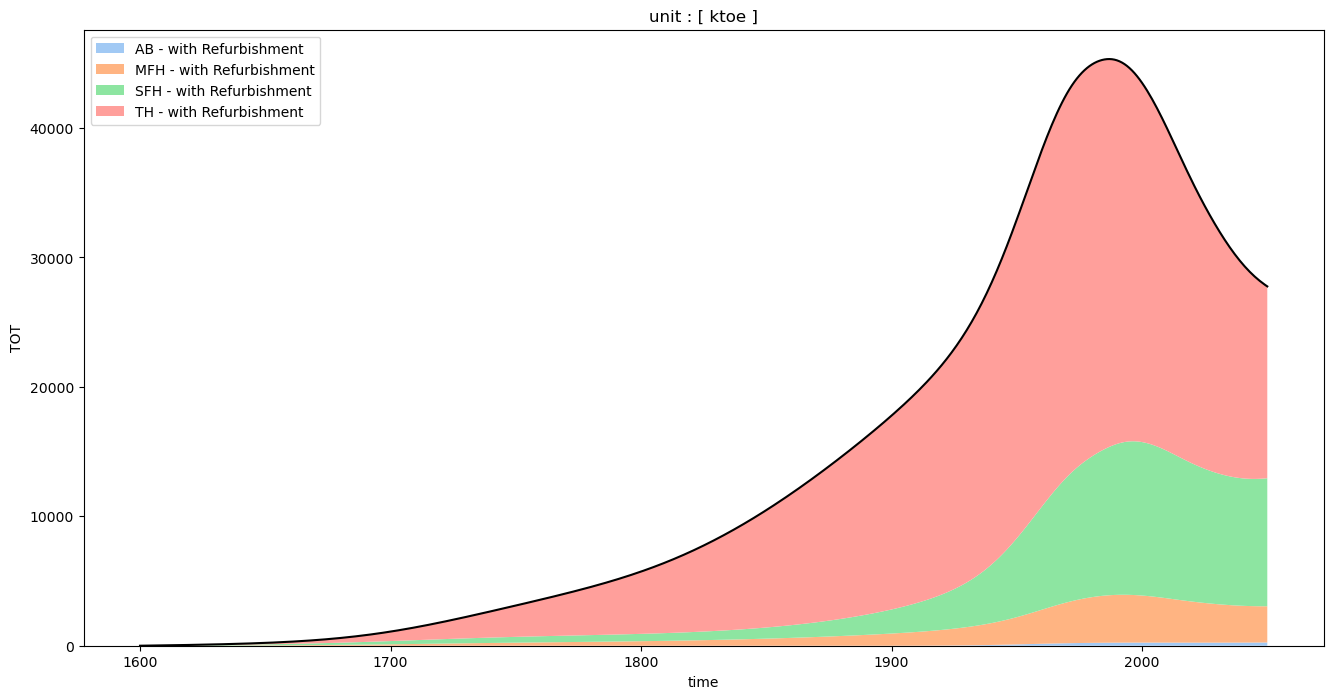

35000
39141.90359413407


In [34]:
display(NRJ_Reno_Time_ktoe)

stack_NRJ_Reno_Time_ktoe = [NRJ_Reno_Time_ktoe[k].to_list() for k in TYP[1:]]
lab = [str(k+' - with Refurbishment') for k in TYP[1:]]
colors = sns.color_palette('pastel')[0:4]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_Reno_Time_ktoe.index,stack_NRJ_Reno_Time_ktoe, labels=lab, colors=colors)
sns.lineplot(data=NRJ_Reno_Time_ktoe,x=NRJ_Reno_Time_ktoe.index,y='TOT',color='black')
plt.title('unit : [ ktoe ]')
fig = ax.get_figure()
fig.savefig("Output/Energy/ktoe_per_type_Reno.png",dpi=300,bbox_inches="tight")
plt.show()

MTOE_data = 35000
print(MTOE_data)

print(NRJ_Reno_Time_ktoe.loc[2012,'TOT'])

In [36]:
def ED_to_FEC(NRJ_FEC_Time,NRJ_ED_Time,NRJ_efficiency_mean):
    for k in NRJ_FEC_Time.columns:
        NRJ_FEC_Time[k] = NRJ_ED_Time[k]/NRJ_efficiency_mean['Efficiency']
    return NRJ_FEC_Time

In [82]:
NRJ_Reno_FEC_bau_ktoe = NRJ_Reno_Time_ktoe.copy(deep=True)
NRJ_Reno_FEC_bau_ktoe = ED_to_FEC(NRJ_Reno_FEC_bau_ktoe,NRJ_Reno_Time_ktoe,NRJ_EFF_bau)

NRJ_Reno_FEC_half_ktoe = NRJ_Reno_Time_ktoe.copy(deep=True)
NRJ_Reno_FEC_half_ktoe = ED_to_FEC(NRJ_Reno_FEC_half_ktoe,NRJ_Reno_Time_ktoe,NRJ_EFF_half)

NRJ_Reno_FEC_iea_ktoe = NRJ_Reno_Time_ktoe.copy(deep=True)
NRJ_Reno_FEC_iea_ktoe = ED_to_FEC(NRJ_Reno_FEC_iea_ktoe,NRJ_Reno_Time_ktoe,NRJ_EFF_iea)

display(NRJ_Reno_Time_ktoe)
display(NRJ_Reno_FEC_bau_ktoe)
display(NRJ_Reno_FEC_half_ktoe)
display(NRJ_Reno_FEC_iea_ktoe)

,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,2.591577,0.0,0.448006,1.21793,0.925641
1602,5.226159,0.0,0.900147,2.445076,1.880936
1603,7.9113,0.0,1.357622,3.684623,2.869055
1604,10.646782,0.0,1.820278,4.936072,3.890432
...,...,...,...,...,...
2046,28344.997299,247.191408,2805.303953,9837.204666,15455.297272
2047,28184.464881,248.156532,2802.135796,9846.492208,15287.680345
2048,28033.515993,249.174482,2799.821836,9858.764385,15125.75529


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,30691.666095,267.656267,3037.553728,10651.622145,16734.833955
2047,30517.843274,268.701293,3034.123281,10661.678597,16553.340103
2048,30354.397401,269.803518,3031.617749,10674.966783,16378.00935


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,35059.171929,305.744467,3469.805714,12167.376347,19116.245401
2047,35138.898291,309.388423,3493.554522,12276.085059,19059.870287
2048,35231.28836,313.151516,3518.692785,12390.060919,19009.383141


,TOT,AB,MFH,SFH,TH
time,,,,,
1600,0.0,0.0,0.0,0.0,0.0
1601,3.239472,0.0,0.560008,1.522412,1.157052
1602,6.532699,0.0,1.125184,3.056345,2.35117
1603,9.889125,0.0,1.697027,4.605779,3.586319
1604,13.308477,0.0,2.275348,6.17009,4.86304
...,...,...,...,...,...
2046,41517.575552,362.066994,4108.993823,14408.782038,22637.732697
2047,42030.688657,370.068759,4178.745196,14683.793008,22798.081694
2048,42573.662649,378.413836,4252.005719,14972.210734,22971.03236


In [83]:
def display_NRJ(NRJ_Time_Table,unit,state,save_file=None,T=TYP):
    stack_NRJ_Time_Table = [NRJ_Time_Table[k].to_list() for k in T[1:]]
    lab = [str(k+state) for k in T[1:]]
    colors = sns.color_palette('pastel')[0:4]
    ax = plt.figure(figsize=(16,8))
    plt.stackplot(NRJ_Time_Table.index,stack_NRJ_Time_Table, labels=lab, colors=colors)
    sns.lineplot(data=NRJ_Time_Table,x=NRJ_Time_Table.index,y='TOT',color='black')
    plt.title('unit : [ '+unit+' ]')
    if type(save_file)==str:
        fig = ax.get_figure()
        fig.savefig("Output/"+save_file,dpi=300,bbox_inches="tight")
    plt.show()
    return

def display_NRJ_xlim(NRJ_Time_Table,unit,state,start,end,save_file=None,T=TYP):
    stack_NRJ_Time_Table = [NRJ_Time_Table[k].to_list() for k in T[1:]]
    lab = [str(k+state) for k in T[1:]]
    colors = sns.color_palette('pastel')[0:4]
    ax = plt.figure(figsize=(16,8))
    plt.stackplot(NRJ_Time_Table.index,stack_NRJ_Time_Table, labels=lab, colors=colors)
    sns.lineplot(data=NRJ_Time_Table,x=NRJ_Time_Table.index,y='TOT',color='black')
    plt.title('unit : [ '+unit+' ]')
    if type(save_file)==str:
        fig = ax.get_figure()
        fig.savefig("Output/"+save_file,dpi=300,bbox_inches="tight")
    plt.xlim(start,end)
    return

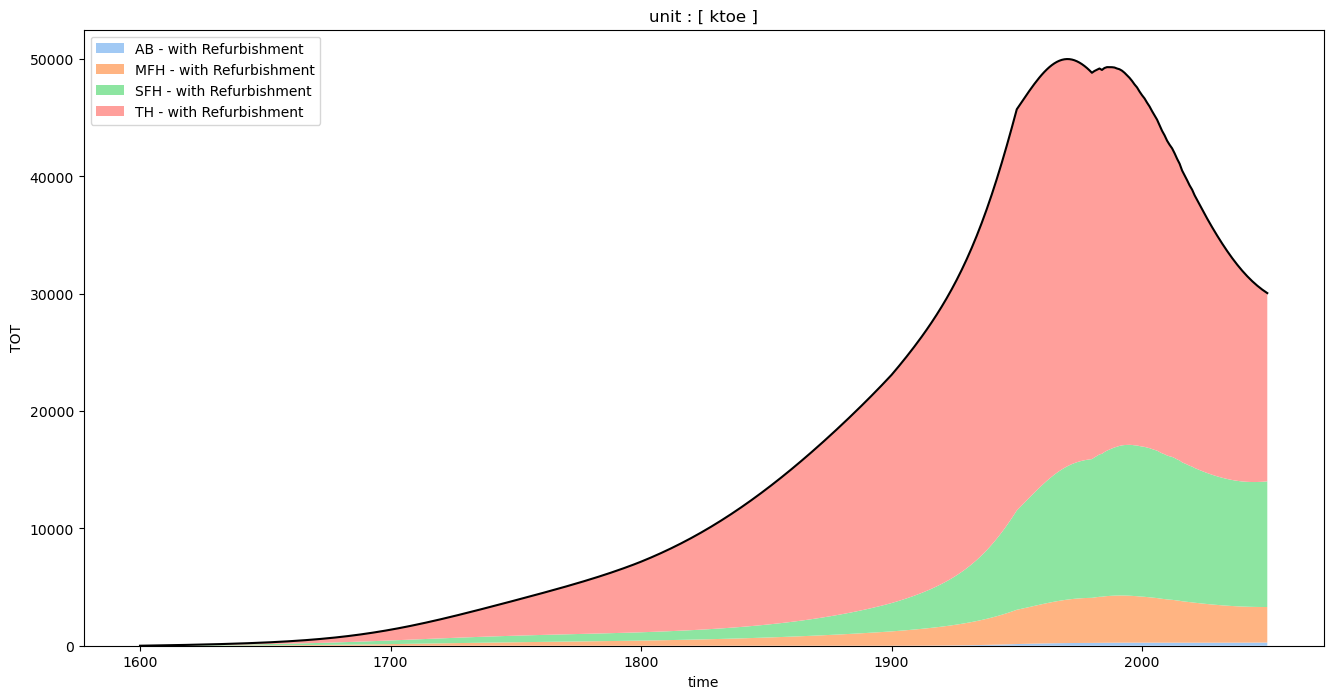

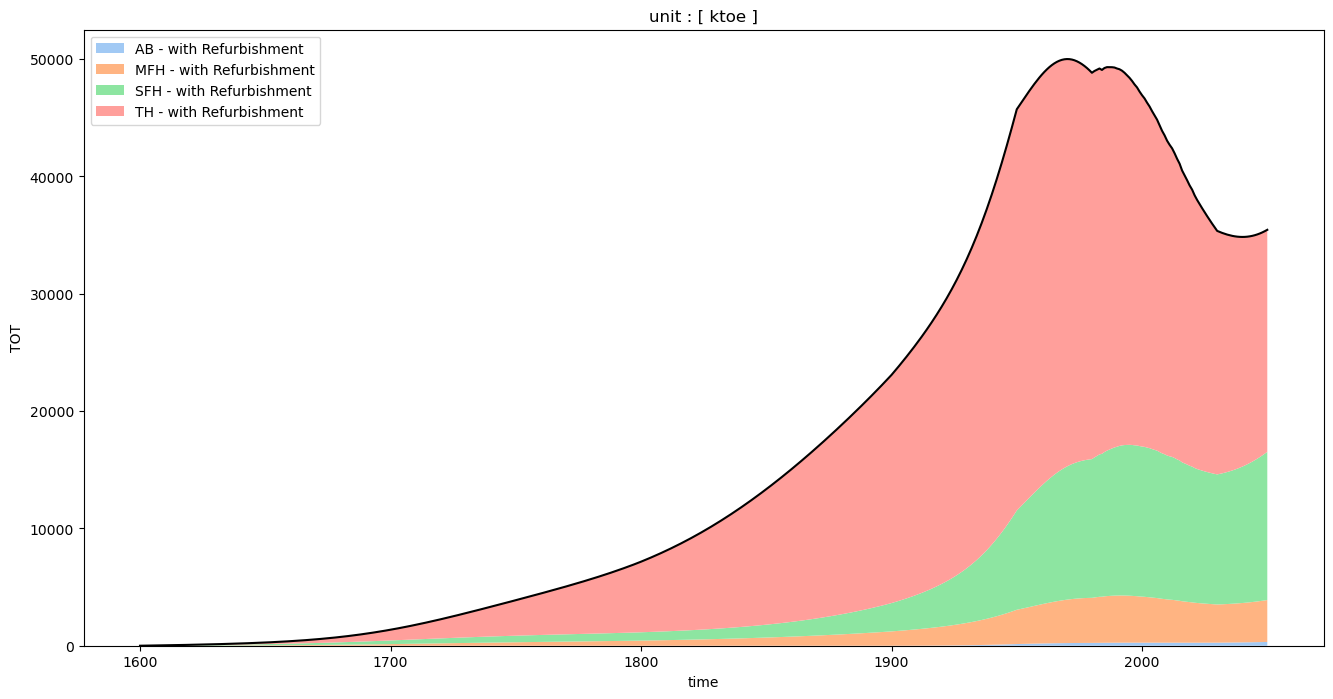

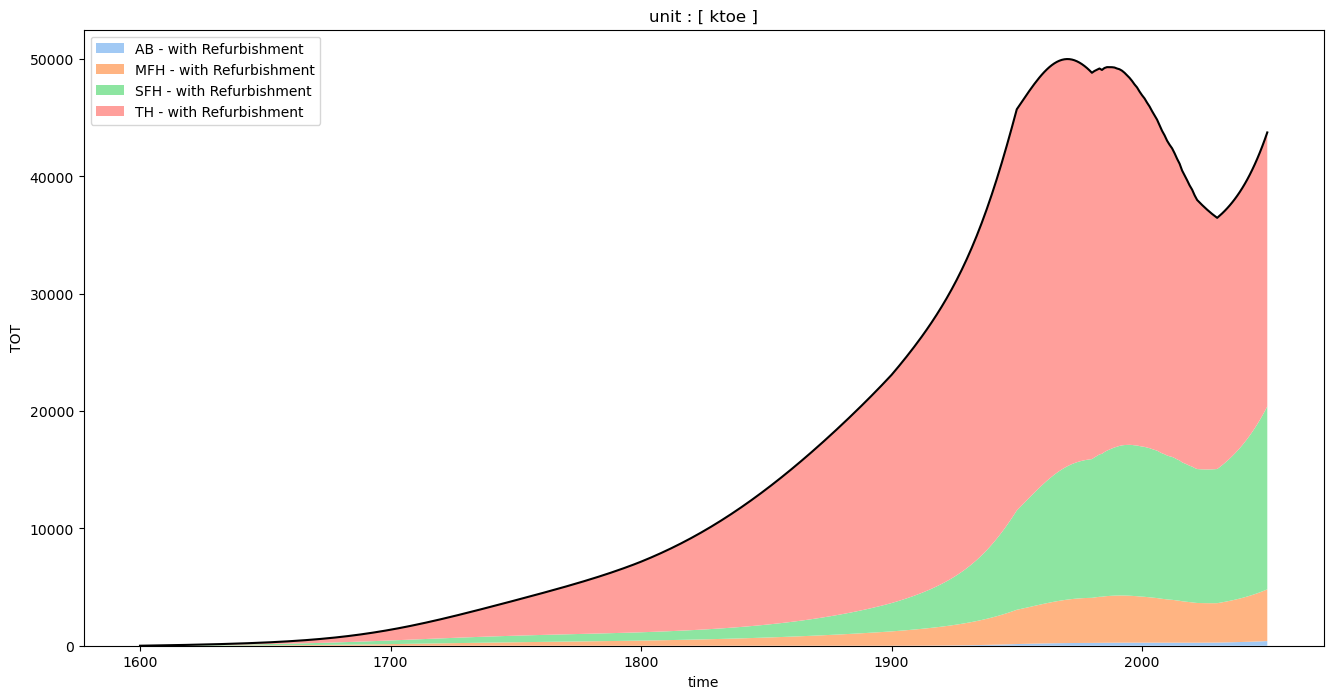

In [85]:
display_NRJ(NRJ_Reno_FEC_bau_ktoe,'ktoe',' - with Refurbishment')#,'Energy/ktoe_per_type_Reno_FEC.png')
display_NRJ(NRJ_Reno_FEC_half_ktoe,'ktoe',' - with Refurbishment')#,'Energy/ktoe_per_type_Reno_FEC.png')
display_NRJ(NRJ_Reno_FEC_iea_ktoe,'ktoe',' - with Refurbishment')#,'Energy/ktoe_per_type_Reno_FEC.png')

In [145]:
print(NRJ_Reno_FEC_bau_ktoe.loc[2050,'TOT'])
print(NRJ_Reno_FEC_half_ktoe.loc[2050,'TOT'])
print(NRJ_Reno_FEC_iea_ktoe.loc[2050,'TOT'])

print((NRJ_Reno_FEC_iea_ktoe.loc[2050,'TOT']-NRJ_Reno_FEC_bau_ktoe.loc[2050,'TOT'])/NRJ_Reno_FEC_bau_ktoe.loc[2050,'TOT'])

30057.190182129736
35453.580279804235
43753.43427885019
0.4556728028710896


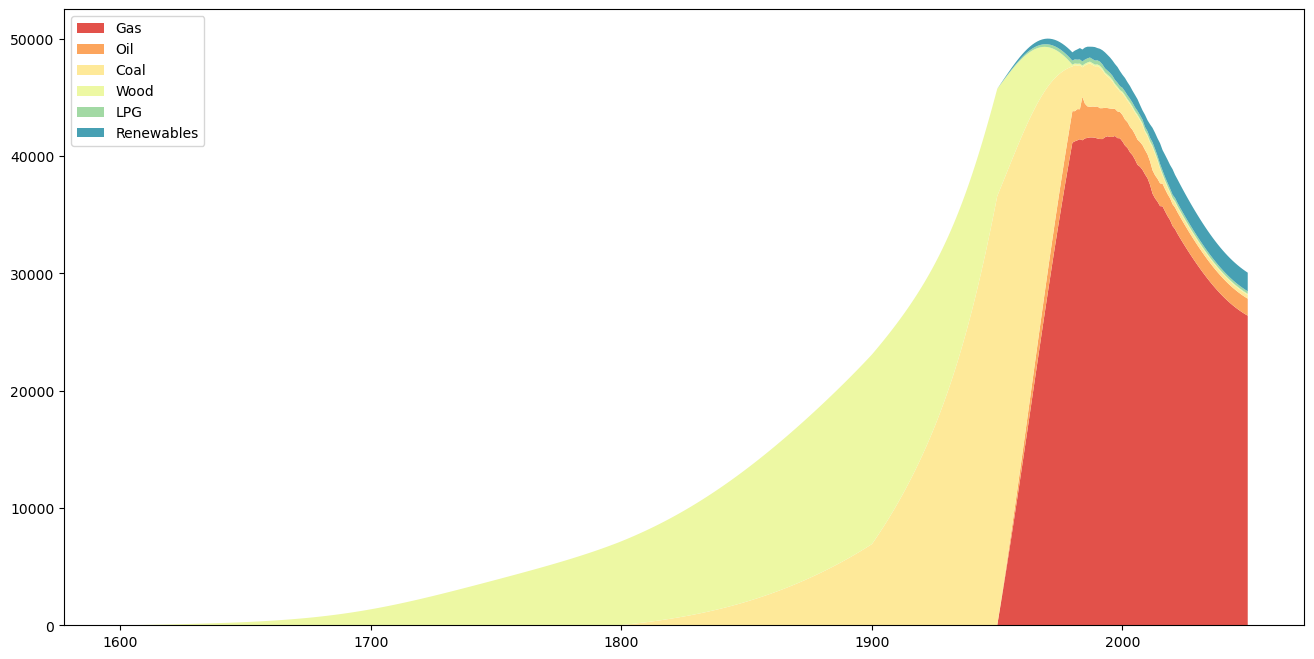

,Gas,Oil,Coal,Wood,LPG,Renewables
1600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0.000000,0.000000,0.000000,0.941876,0.000000,0.000000
1602,0.000000,0.000000,0.000000,1.899382,0.000000,0.000000
1603,0.000000,0.000000,0.000000,2.875263,0.000000,0.000000
1604,0.000000,0.000000,0.000000,3.869440,0.000000,0.000000
...,...,...,...,...,...,...
2046,57980.243262,4392.186108,1562.022041,27.150919,557.498862,565.793751
2047,57651.871078,4367.310881,1553.175500,26.997149,554.341457,562.589367
2048,57343.102193,4343.920665,1544.857083,26.852559,551.372544,559.576281
2049,57053.270121,4321.964972,1537.048836,26.716837,548.585714,556.747987


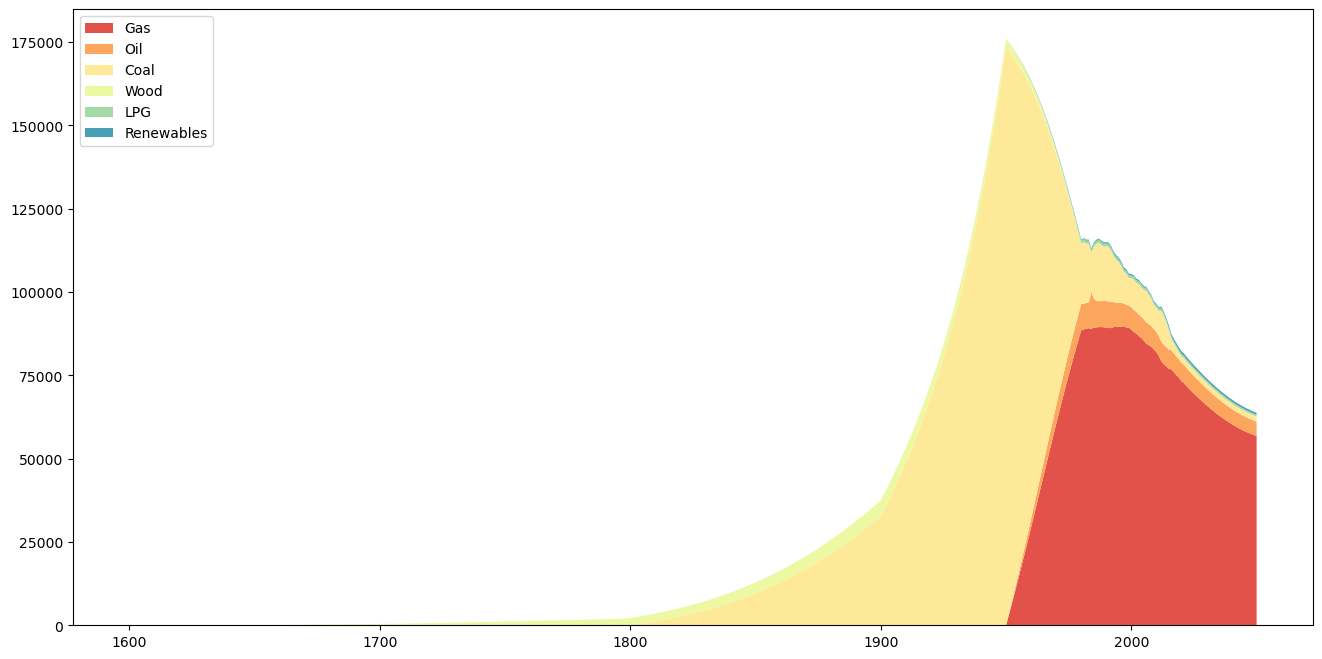

In [86]:
NRJ_FEC_bau_ktoe = NRJ_FEC_bau.copy(deep=True)

for i in NRJ_FEC_bau_ktoe.index:
    for j in NRJ_FEC_bau_ktoe.columns:
        NRJ_FEC_bau_ktoe.loc[i,j] = NRJ_FEC_bau.loc[i,j]*NRJ_Reno_FEC_bau_ktoe.loc[i,'TOT']

#display(NRJ_FEC_bau_ktoe)

colors = sns.color_palette("Spectral")[0:7]

stack_NRJ_FEC_bau_ktoe = [NRJ_FEC_bau_ktoe[k].to_list() for k in NRJ_FEC_bau_ktoe.columns]
lab = [str(k) for k in NRJ_FEC_bau_ktoe.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_bau_ktoe.index,stack_NRJ_FEC_bau_ktoe, labels=lab, colors=colors)
plt.legend(loc='upper left')
#fig = ax.get_figure()
#fig.savefig("Output/Energy/fec-sources-ktoe.png",dpi=300,bbox_inches="tight")
plt.show()

NRJ_FEC_bau_CO2 = NRJ_FEC_bau_ktoe.copy(deep=True)

#display(NRJ_CO2)

for i in NRJ_FEC_bau_CO2.index:
    for j in NRJ_FEC_bau_CO2.columns:
        co2_ktCO2_per_ktoe = NRJ_CO2.loc[i,j]*11.63
        NRJ_FEC_bau_CO2.loc[i,j] = NRJ_FEC_bau_ktoe.loc[i,j]*co2_ktCO2_per_ktoe

#print(co2_ktCO2_per_ktoe)
#display(NRJ_CO2)
display(NRJ_FEC_bau_CO2)

stack_NRJ_FEC_bau_CO2 = [NRJ_FEC_bau_CO2[k].to_list() for k in NRJ_FEC_bau_CO2.columns]
lab = [str(k) for k in NRJ_FEC_bau_CO2.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_bau_CO2.index,stack_NRJ_FEC_bau_CO2, labels=lab, colors=colors)
plt.legend(loc='upper left')
#fig = ax.get_figure()
#fig.savefig("Output/Energy/fec-sources-ktCO2.png",dpi=300,bbox_inches="tight")
plt.show()

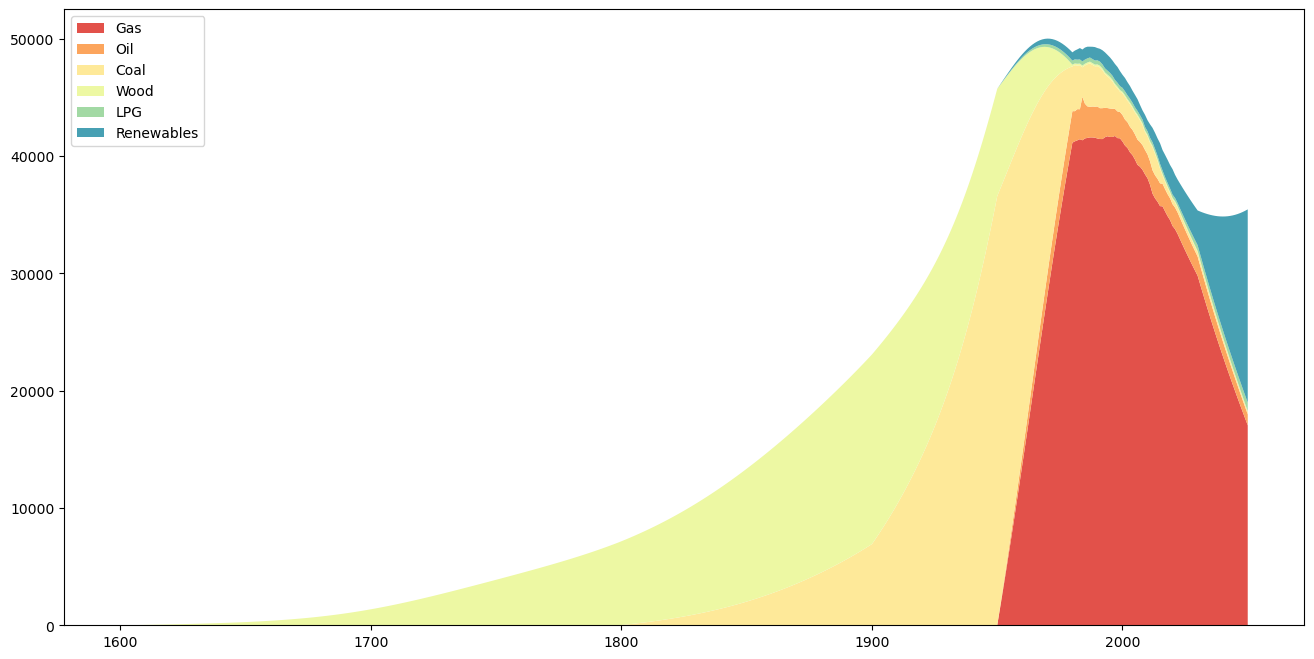

,Gas,Oil,Coal,Wood,LPG,Renewables
1600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0.000000,0.000000,0.000000,0.941876,0.000000,0.000000
1602,0.000000,0.000000,0.000000,1.899382,0.000000,0.000000
1603,0.000000,0.000000,0.000000,2.875263,0.000000,0.000000
1604,0.000000,0.000000,0.000000,3.869440,0.000000,0.000000
...,...,...,...,...,...,...
2046,41624.186964,3153.163310,1121.380212,19.491724,1721.342445,4770.642358
2047,40371.838276,3058.293951,1087.641197,18.905276,1754.006800,5011.436919
2048,39130.603485,2964.266505,1054.201598,18.324032,1787.376612,5254.624059
2049,37898.927315,2870.963154,1021.019514,17.747264,1821.477019,5500.432608


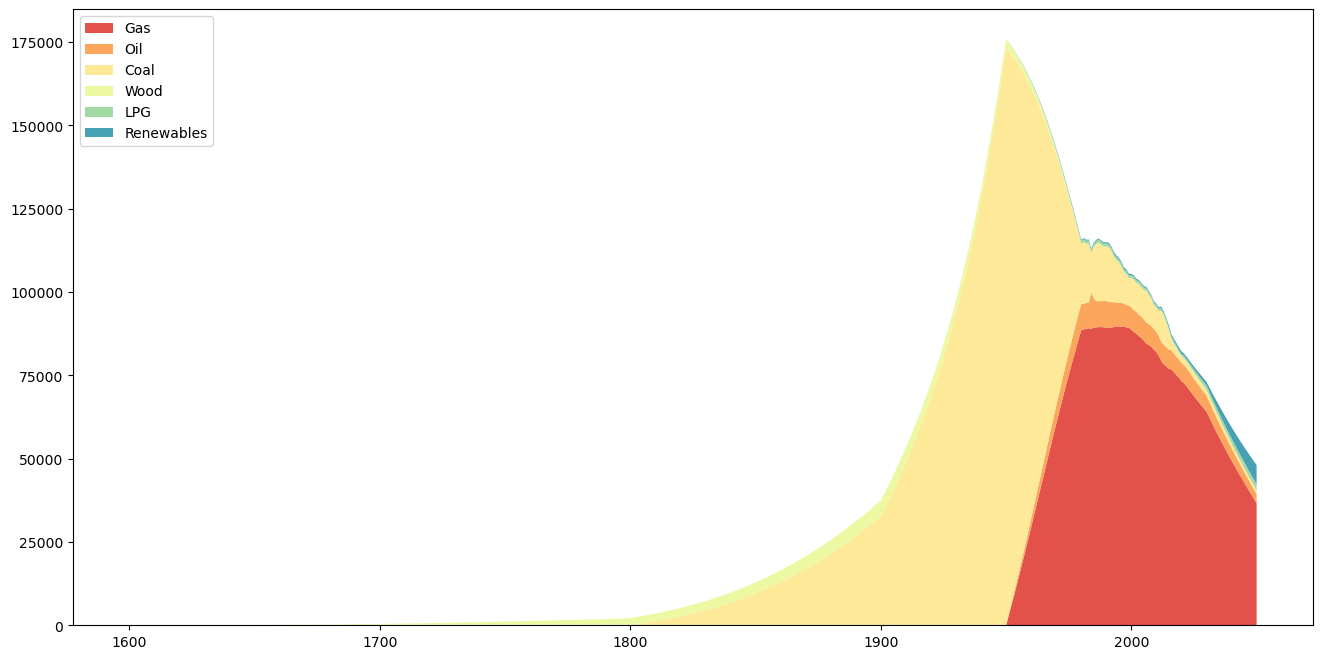

In [91]:
NRJ_FEC_half_ktoe = NRJ_FEC_half.copy(deep=True)

for i in NRJ_FEC_half_ktoe.index:
    for j in NRJ_FEC_half_ktoe.columns:
        NRJ_FEC_half_ktoe.loc[i,j] = NRJ_FEC_half.loc[i,j]*NRJ_Reno_FEC_half_ktoe.loc[i,'TOT']

#display(NRJ_FEC_half_ktoe)

colors = sns.color_palette("Spectral")[0:7]

stack_NRJ_FEC_half_ktoe = [NRJ_FEC_half_ktoe[k].to_list() for k in NRJ_FEC_half_ktoe.columns]
lab = [str(k) for k in NRJ_FEC_half_ktoe.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_half_ktoe.index,stack_NRJ_FEC_half_ktoe, labels=lab, colors=colors)
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-halfway-ktoe.png",dpi=300,bbox_inches="tight")
plt.show()

NRJ_FEC_half_CO2 = NRJ_FEC_half_ktoe.copy(deep=True)

#display(NRJ_CO2)

for i in NRJ_FEC_half_CO2.index:
    for j in NRJ_FEC_half_CO2.columns:
        co2_ktCO2_per_ktoe = NRJ_CO2.loc[i,j]*11.63
        NRJ_FEC_half_CO2.loc[i,j] = NRJ_FEC_half_ktoe.loc[i,j]*co2_ktCO2_per_ktoe

#print(co2_ktCO2_per_ktoe)
#display(NRJ_CO2)
display(NRJ_FEC_half_CO2)

stack_NRJ_FEC_half_CO2 = [NRJ_FEC_half_CO2[k].to_list() for k in NRJ_FEC_half_CO2.columns]
lab = [str(k) for k in NRJ_FEC_half_CO2.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_half_CO2.index,stack_NRJ_FEC_half_CO2, labels=lab, colors=colors)
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-halfway-ktCO2.png",dpi=300,bbox_inches="tight")
plt.show()

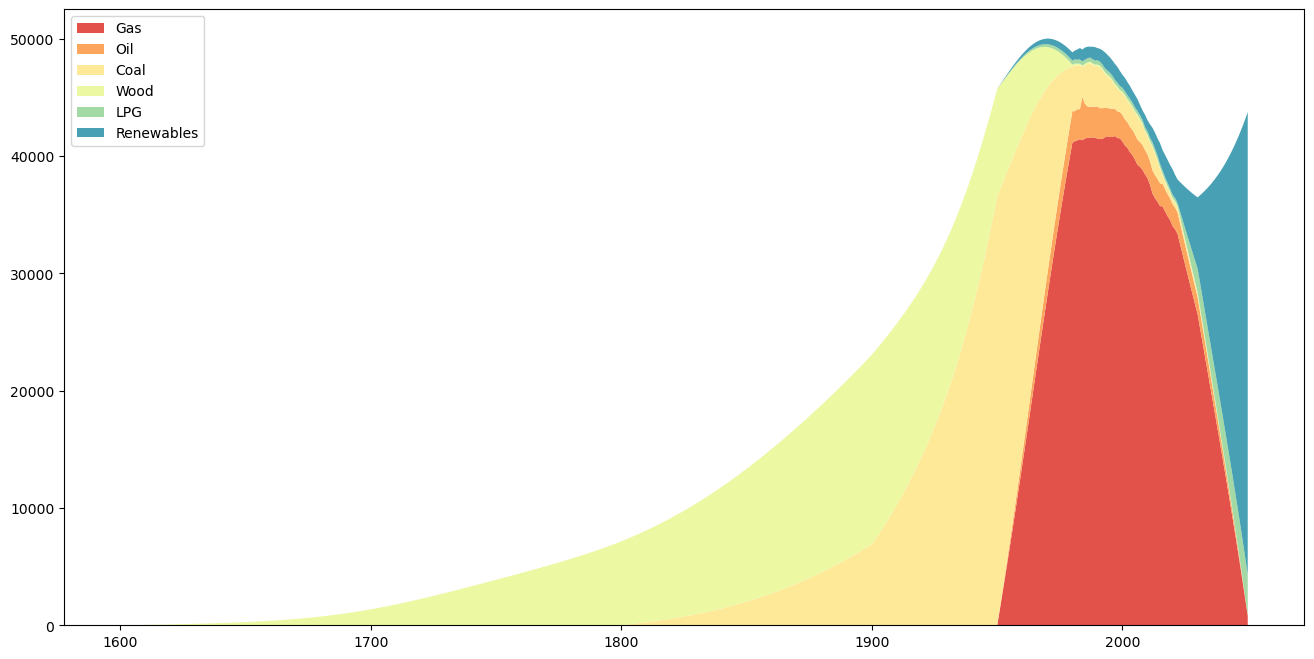

,Gas,Oil,Coal,Wood,LPG,Renewables
1600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0.000000,0.000000,0.000000,0.941876,0.000000,0.000000
1602,0.000000,0.000000,0.000000,1.899382,0.000000,0.000000
1603,0.000000,0.000000,0.000000,2.875263,0.000000,0.000000
1604,0.000000,0.000000,0.000000,3.869440,0.000000,0.000000
...,...,...,...,...,...,...
2046,13817.076822,1046.687103,372.240220,6.470244,7940.735129,11003.739400
2047,10881.711494,824.323931,293.159743,5.095675,8163.440818,11662.032525
2048,7890.596688,597.737560,212.577341,3.694999,8394.492046,12339.285287
2049,4837.716278,366.472251,130.330937,2.265400,8634.346296,13036.848509


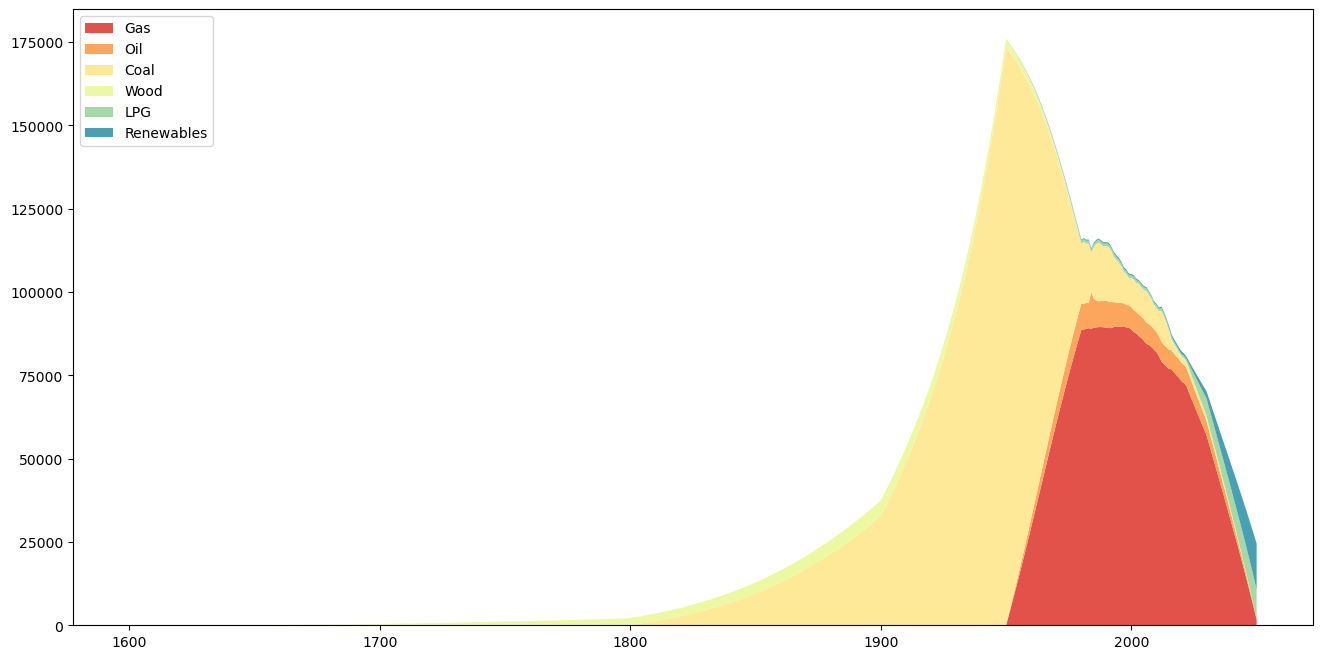

In [92]:
NRJ_FEC_iea_ktoe = NRJ_FEC_iea.copy(deep=True)

for i in NRJ_FEC_iea_ktoe.index:
    for j in NRJ_FEC_iea_ktoe.columns:
        NRJ_FEC_iea_ktoe.loc[i,j] = NRJ_FEC_iea.loc[i,j]*NRJ_Reno_FEC_iea_ktoe.loc[i,'TOT']

#display(NRJ_FEC_iea_ktoe)

colors = sns.color_palette("Spectral")[0:7]

stack_NRJ_FEC_iea_ktoe = [NRJ_FEC_iea_ktoe[k].to_list() for k in NRJ_FEC_iea_ktoe.columns]
lab = [str(k) for k in NRJ_FEC_iea_ktoe.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_iea_ktoe.index,stack_NRJ_FEC_iea_ktoe, labels=lab, colors=colors)
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-iea-ktoe.png",dpi=300,bbox_inches="tight")
plt.show()

NRJ_FEC_iea_CO2 = NRJ_FEC_iea_ktoe.copy(deep=True)

#display(NRJ_CO2)

for i in NRJ_FEC_iea_CO2.index:
    for j in NRJ_FEC_iea_CO2.columns:
        co2_ktCO2_per_ktoe = NRJ_CO2.loc[i,j]*11.63
        NRJ_FEC_iea_CO2.loc[i,j] = NRJ_FEC_iea_ktoe.loc[i,j]*co2_ktCO2_per_ktoe

#print(co2_ktCO2_per_ktoe)
#display(NRJ_CO2)
display(NRJ_FEC_iea_CO2)

stack_NRJ_FEC_iea_CO2 = [NRJ_FEC_iea_CO2[k].to_list() for k in NRJ_FEC_iea_CO2.columns]
lab = [str(k) for k in NRJ_FEC_iea_CO2.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_iea_CO2.index,stack_NRJ_FEC_iea_CO2, labels=lab, colors=colors)
plt.legend(loc='upper left')
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-iea-ktCO2.png",dpi=300,bbox_inches="tight")
plt.show()

In [153]:
display(NRJ_FEC_bau_ktoe)

,Gas,Oil,Coal,Wood,LPG,Renewables
1600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,0.000000,0.000000,0.000000,3.239472,0.000000,0.000000
1602,0.000000,0.000000,0.000000,6.532699,0.000000,0.000000
1603,0.000000,0.000000,0.000000,9.889125,0.000000,0.000000
1604,0.000000,0.000000,0.000000,13.308477,0.000000,0.000000
...,...,...,...,...,...,...
2046,26948.127286,1481.019712,329.594404,93.382351,217.892153,1621.650189
2047,26795.506067,1472.631929,327.727740,92.853479,216.658117,1612.465943
2048,26651.996093,1464.744884,325.972513,92.356179,215.497750,1603.829982
2049,26517.287593,1457.341552,324.324934,91.889378,214.408549,1595.723665


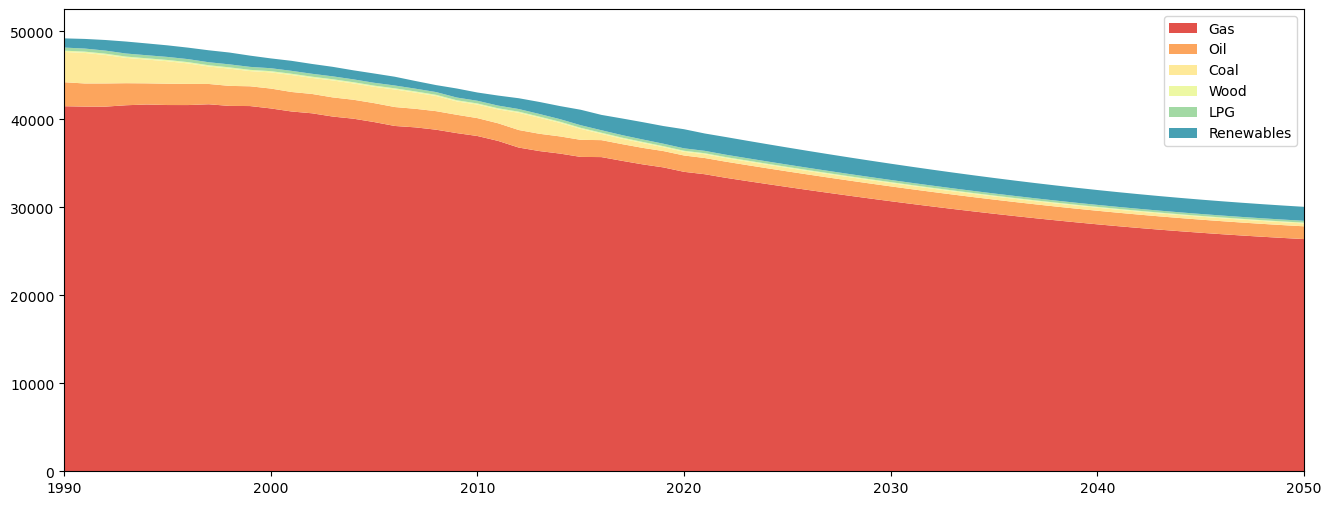

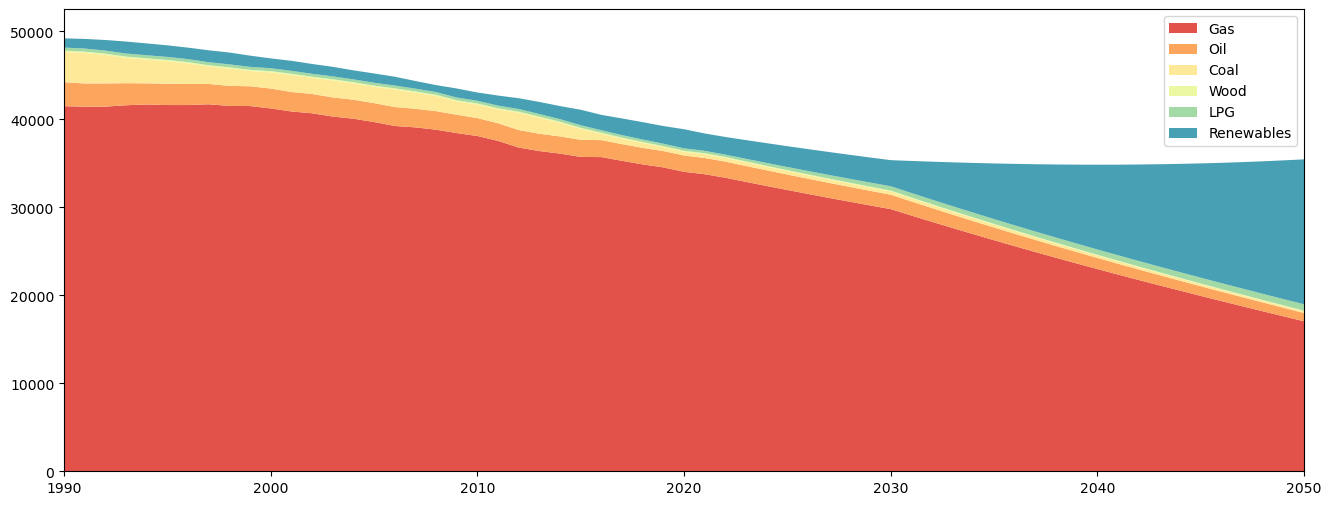

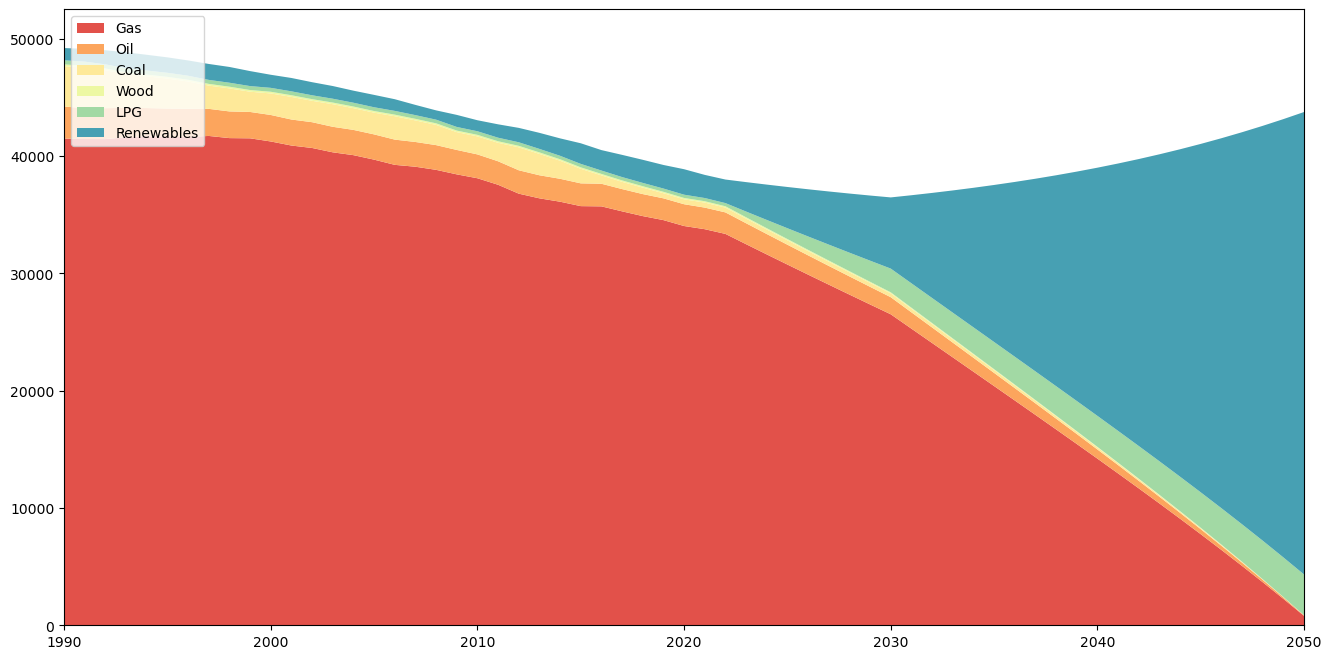

In [156]:
colors = sns.color_palette("Spectral")[0:7]

ax = plt.figure(figsize=(16,6))
plt.stackplot(NRJ_FEC_bau_ktoe.index,stack_NRJ_FEC_bau_ktoe, labels=lab, colors=colors)
plt.legend(loc='upper right')
plt.xlim(1990,2050)
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-bau-zoom-ktoe.png",dpi=300,bbox_inches="tight")
plt.show()

ax = plt.figure(figsize=(16,6))
plt.stackplot(NRJ_FEC_half_ktoe.index,stack_NRJ_FEC_half_ktoe, labels=lab, colors=colors)
plt.legend(loc='upper right')
plt.xlim(1990,2050)
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-halfway-zoom-ktoe.png",dpi=300,bbox_inches="tight")
plt.show()

#stack_NRJ_FEC_iea_ktoe = [NRJ_FEC_iea_ktoe[k].to_list() for k in NRJ_FEC_iea_ktoe.columns]
#lab = [str(k) for k in NRJ_FEC_iea_ktoe.columns]

ax = plt.figure(figsize=(16,8))
plt.stackplot(NRJ_FEC_iea_ktoe.index,stack_NRJ_FEC_iea_ktoe, labels=lab, colors=colors)
plt.legend(loc='upper left')
plt.xlim(1990,2050)
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-iea-zoom-ktoe.png",dpi=300,bbox_inches="tight")
plt.show()

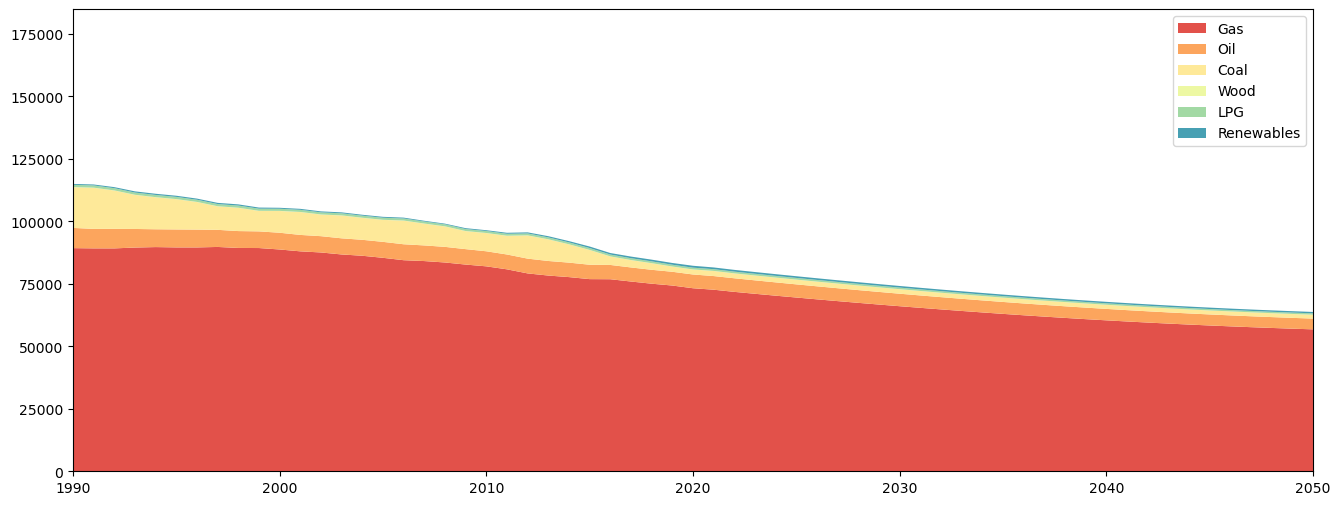

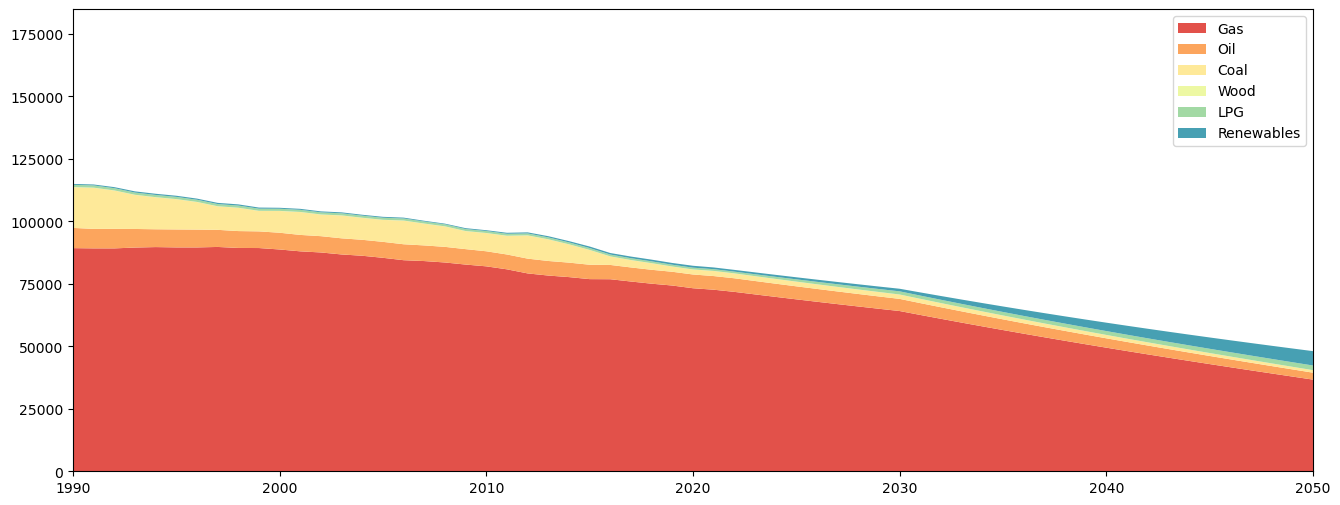

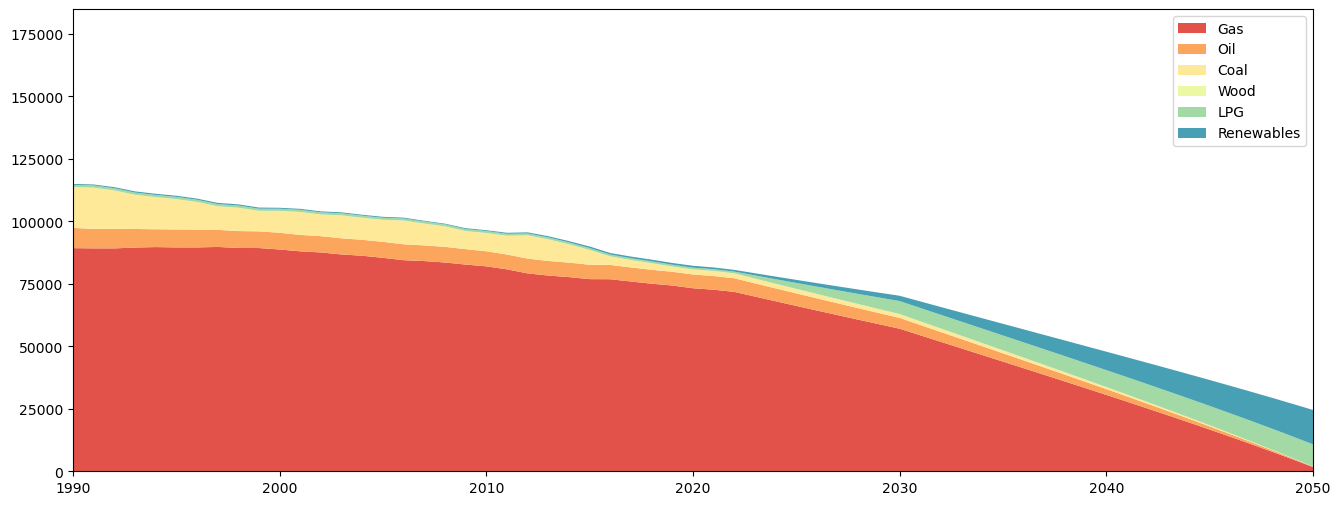

In [106]:
ax = plt.figure(figsize=(16,6))
plt.stackplot(NRJ_FEC_bau_CO2.index,stack_NRJ_FEC_bau_CO2, labels=lab, colors=colors)
plt.legend(loc='upper right')
plt.xlim(1990,2050)
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-bau-zoom-ktCO2.png",dpi=300,bbox_inches="tight")
plt.show()

ax = plt.figure(figsize=(16,6))
plt.stackplot(NRJ_FEC_half_CO2.index,stack_NRJ_FEC_half_CO2, labels=lab, colors=colors)
plt.legend(loc='upper right')
plt.xlim(1990,2050)
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-halfway-zoom-ktCO2.png",dpi=300,bbox_inches="tight")
plt.show()

ax = plt.figure(figsize=(16,6))
plt.stackplot(NRJ_FEC_iea_CO2.index,stack_NRJ_FEC_iea_CO2, labels=lab, colors=colors)
plt.legend(loc='upper right')
plt.xlim(1990,2050)
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-iea-zoom-ktCO2.png",dpi=300,bbox_inches="tight")
plt.show()

In [202]:
print(NRJ_FEC_bau_CO2.loc[2022,:].sum())

print('2050 levels')

print(NRJ_FEC_bau_CO2.loc[2050,:].sum())
print(NRJ_FEC_half_CO2.loc[2050,:].sum())
print(NRJ_FEC_iea_CO2.loc[2050,:].sum())

print((NRJ_FEC_iea_CO2.loc[2050,:].sum()-NRJ_FEC_bau_CO2.loc[2050,:].sum())/NRJ_FEC_bau_CO2.loc[2050,:].sum())

print('-4 pourcent annually until 2030 in ED => ED unchanged !')

print('-19 pourcent compared to 2018 levels - UK GBC ?')

print('2023 compared to 2018 levels?')

print(NRJ_FEC_bau_CO2.loc[2023,:].sum(),(NRJ_FEC_bau_CO2.loc[2023,:].sum()-NRJ_FEC_bau_CO2.loc[2018,:].sum())/NRJ_FEC_bau_CO2.loc[2018,:].sum())
print(NRJ_FEC_half_CO2.loc[2023,:].sum(),(NRJ_FEC_half_CO2.loc[2023,:].sum()-NRJ_FEC_half_CO2.loc[2018,:].sum())/NRJ_FEC_half_CO2.loc[2018,:].sum())
print(NRJ_FEC_iea_CO2.loc[2023,:].sum(),(NRJ_FEC_iea_CO2.loc[2023,:].sum()-NRJ_FEC_iea_CO2.loc[2018,:].sum())/NRJ_FEC_iea_CO2.loc[2018,:].sum())

print('2030 compared to 1990 levels?')

print(NRJ_FEC_bau_CO2.loc[2030,:].sum(),(NRJ_FEC_bau_CO2.loc[2030,:].sum()-NRJ_FEC_bau_CO2.loc[1990,:].sum())/NRJ_FEC_bau_CO2.loc[1990,:].sum())
print(NRJ_FEC_half_CO2.loc[2030,:].sum(),(NRJ_FEC_half_CO2.loc[2030,:].sum()-NRJ_FEC_half_CO2.loc[1990,:].sum())/NRJ_FEC_half_CO2.loc[1990,:].sum())
print(NRJ_FEC_iea_CO2.loc[2030,:].sum(),(NRJ_FEC_iea_CO2.loc[2030,:].sum()-NRJ_FEC_iea_CO2.loc[1990,:].sum())/NRJ_FEC_iea_CO2.loc[1990,:].sum())

print('2050 compared to 1990 levels?')

print(NRJ_FEC_bau_CO2.loc[2050,:].sum(),(NRJ_FEC_bau_CO2.loc[2050,:].sum()-NRJ_FEC_bau_CO2.loc[1990,:].sum())/NRJ_FEC_bau_CO2.loc[1990,:].sum())
print(NRJ_FEC_half_CO2.loc[2050,:].sum(),(NRJ_FEC_half_CO2.loc[2050,:].sum()-NRJ_FEC_half_CO2.loc[1990,:].sum())/NRJ_FEC_half_CO2.loc[1990,:].sum())
print(NRJ_FEC_iea_CO2.loc[2050,:].sum(),(NRJ_FEC_iea_CO2.loc[2050,:].sum()-NRJ_FEC_iea_CO2.loc[1990,:].sum())/NRJ_FEC_iea_CO2.loc[1990,:].sum())

80573.7175998638
2050 levels
63739.42226627814
48064.13071915856
24533.50579248917
-0.6150968283019906
-4 pourcent annually until 2030 in ED => ED unchanged !
-19 pourcent compared to 2018 levels - UK GBC ?
2023 compared to 2018 levels?
79709.85059966809 -0.05852571604729274
79569.3806117559 -0.06018484450245291
79223.5082282696 -0.06427003538077003
2030 compared to 1990 levels?
74130.50615325944 -0.35516936329527343
73021.65751846369 -0.3648147793093805
70210.98119925002 -0.3892636910265408
2050 compared to 1990 levels?
63739.42226627814 -0.44555710764766737
48064.13071915856 -0.5819099906020069
24533.50579248917 -0.7865931722081692


In [180]:
print('cumulated until 2030 (GtCO2)')

display(NRJ_FEC_bau_CO2.loc[2022:2030,:].sum(axis=1).sum()/10**6)
display(NRJ_FEC_half_CO2.loc[2022:2030,:].sum(axis=1).sum()/10**6)
display(NRJ_FEC_iea_CO2.loc[2022:2030,:].sum(axis=1).sum()/10**6)

print('cumulated until 2050 (GtCO2)')

display(NRJ_FEC_bau_CO2.loc[2022:2050,:].sum(axis=1).sum()/10**6)
display(NRJ_FEC_half_CO2.loc[2022:2050,:].sum(axis=1).sum()/10**6)
display(NRJ_FEC_iea_CO2.loc[2022:2050,:].sum(axis=1).sum()/10**6)

cumulated until 2030 (GtCO2)


0.6954588908435954

0.6904500502784348

0.6778794085321755

cumulated until 2050 (GtCO2)


2.0538215349362825

1.8744719684444726

1.6091643882785476

In [103]:
file = "Data/Data-behind-the-WLC-Roadmap-Progress-Report-UKGBC.xlsx"
UKGBC = pd.read_excel(file)

UKGBC.columns = UKGBC.loc[1,:]
UKGBC = UKGBC.set_index(UKGBC.columns[1])
UKGBC = UKGBC.drop(columns='% split in 2018:')
UKGBC.columns = np.arange(1990,2051)
UKGBC.index.name = None
ind = "Buildings (Domestic) - Operational Carbon"
UKGBC = pd.DataFrame(UKGBC.loc[ind,:])

for i in UKGBC.index:
    UKGBC.loc[i,ind] *= 1000

display(UKGBC)

,Buildings (Domestic) - Operational Carbon
1990,137677.036029
1991,147144.846652
1992,141772.717254
1993,139719.870493
1994,134523.039724
...,...
2046,2039.259722
2047,1576.021848
2048,1178.314880
2049,752.529236


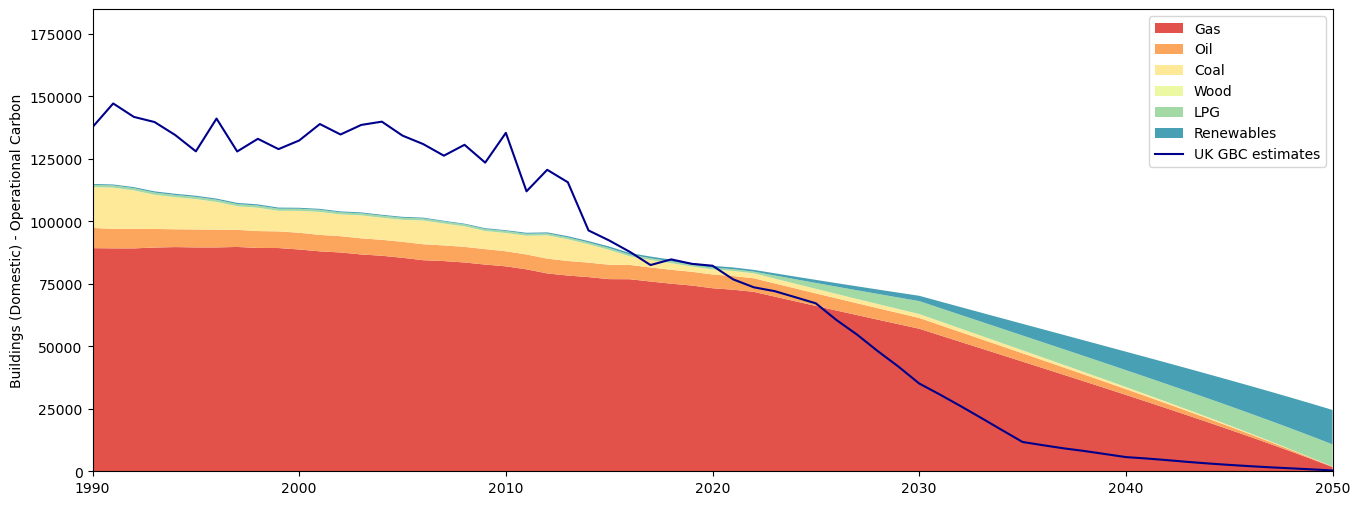

In [107]:
ax = plt.figure(figsize=(16,6))
plt.stackplot(NRJ_FEC_iea_CO2.index,stack_NRJ_FEC_iea_CO2, labels=lab, colors=colors)
sns.lineplot(data=UKGBC,x=UKGBC.index,y=ind,color='darkblue',label='UK GBC estimates')
plt.legend(loc='upper right')
plt.xlim(1990,2050)
fig = ax.get_figure()
fig.savefig("Output/Energy/fec-sources-iea-zoom-ktCO2-ukgbc.png",dpi=300,bbox_inches="tight")
plt.show()

In [113]:
population = pd.read_csv("Model/Population-model.csv")
population = pd.DataFrame(population['DSM'])
population = population.rename(columns={'DSM':'Population'})
population.index = np.arange(1600,2051)
display(population)

,Population
1600,3.776934e+06
1601,3.781226e+06
1602,3.785591e+06
1603,3.790029e+06
1604,3.794541e+06
...,...
2046,6.034675e+07
2047,6.046516e+07
2048,6.058207e+07
2049,6.069751e+07


,FEC
S2,
1600,0.000000
1601,3.239520
1602,6.532796
1603,9.889271
1604,13.308673
...,...
2046,33448.364888
2047,33417.588166
2048,33399.820213


,CO2
S2,
1600,0.000000
1601,0.941890
1602,1.899411
1603,2.875306
1604,3.869497
...,...
2046,70930.763680
2047,70865.498416
2048,70827.819609


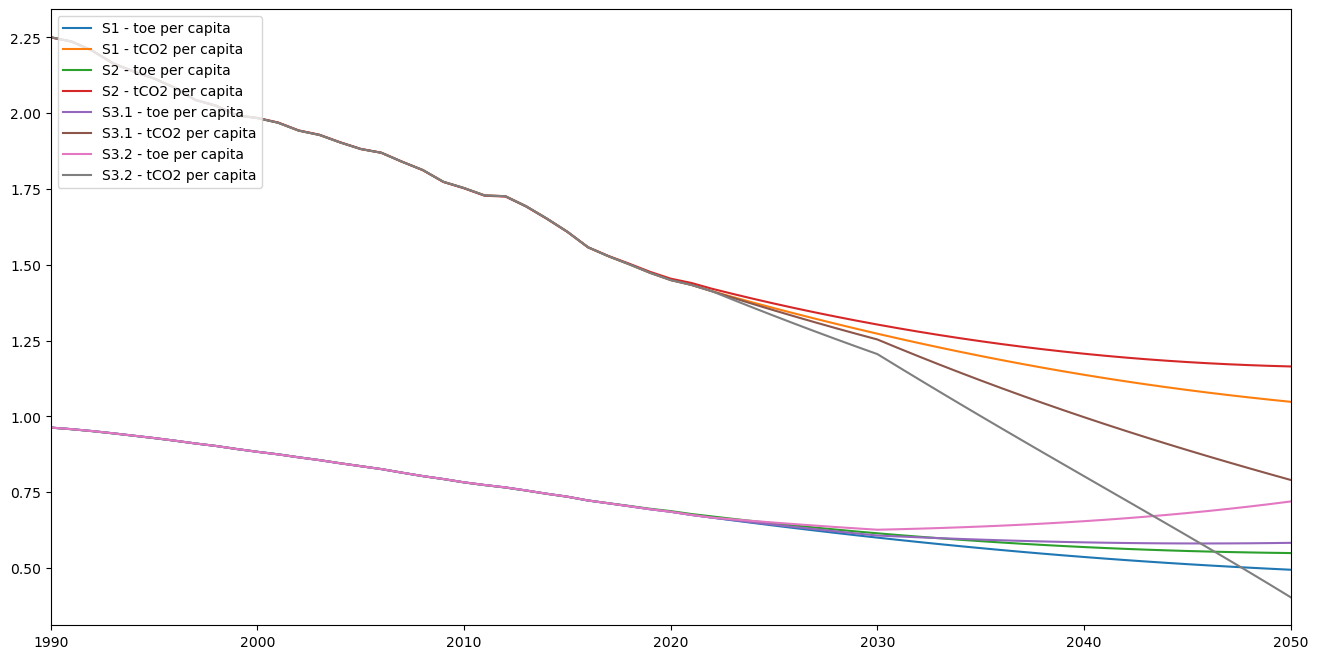

In [201]:
NRJ_FEC_S2_ktoe = pd.read_csv("Model/S2-NRJ_FEC_ktoe.csv")
NRJ_FEC_S2_ktoe = NRJ_FEC_S2_ktoe.set_index('Unnamed: 0')
NRJ_FEC_S2_ktoe.index.name = None
total_NRJ_FEC_S2_ktoe = pd.DataFrame(data=NRJ_FEC_S2_ktoe.sum(axis=1),index=np.arange(1600,2051),columns=['FEC'])
total_NRJ_FEC_S2_ktoe.index.name = 'S2'
display(total_NRJ_FEC_S2_ktoe)

NRJ_FEC_S2_ktCO2 = pd.read_csv("Model/S2-NRJ_FEC_CO2.csv")
NRJ_FEC_S2_ktCO2 = NRJ_FEC_S2_ktCO2.set_index('Unnamed: 0')
NRJ_FEC_S2_ktCO2.index.name = None
total_NRJ_FEC_S2_CO2 = pd.DataFrame(data=NRJ_FEC_S2_ktCO2.sum(axis=1),index=np.arange(1600,2051),columns=['CO2'])
total_NRJ_FEC_S2_CO2.index.name = 'S2'
display(total_NRJ_FEC_S2_CO2)

# S1

total_NRJ_FEC_bau_ktoe = pd.DataFrame(data=NRJ_FEC_bau_ktoe.sum(axis=1),index=np.arange(1600,2051),columns=['FEC'])
total_NRJ_FEC_bau_ktoe.index.name = 'S1'
#display(total_NRJ_FEC_bau_ktoe)

total_NRJ_FEC_bau_CO2 = pd.DataFrame(data=NRJ_FEC_bau_CO2.sum(axis=1),index=np.arange(1600,2051),columns=['CO2'])
total_NRJ_FEC_bau_CO2.index.name = 'S1'
#display(total_NRJ_FEC_bau_CO2)

total_NRJ_FEC_bau_toe_capita = pd.DataFrame(data=(total_NRJ_FEC_bau_ktoe['FEC'][1:]*1000)/population['Population'],columns=['toe per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_bau_toe_capita.index.name = 'S1'
#display(total_NRJ_FEC_bau_toe_capita)

total_NRJ_FEC_bau_tCO2_capita = pd.DataFrame(data=(total_NRJ_FEC_bau_CO2['CO2'][1:]*1000)/population['Population'],columns=['tCO2 per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_bau_tCO2_capita.index.name = 'S1'
#display(total_NRJ_FEC_bau_tCO2_capita)

# S2

#total_NRJ_FEC_S2_ktoe = pd.DataFrame(data=NRJ_FEC_S2_ktoe.sum(axis=1),index=np.arange(1600,2051),columns=['FEC'])
#total_NRJ_FEC_S2_ktoe.index.name = 'S2'
#display(total_NRJ_FEC_bau_ktoe)

#total_NRJ_FEC_S2_CO2 = pd.DataFrame(data=NRJ_FEC_S2_CO2.sum(axis=1),index=np.arange(1600,2051),columns=['CO2'])
#total_NRJ_FEC_S2_CO2.index.name = 'S2'
##display(total_NRJ_FEC_S2_CO2)

total_NRJ_FEC_S2_toe_capita = pd.DataFrame(data=(total_NRJ_FEC_S2_ktoe['FEC'][1:]*1000)/population['Population'],columns=['toe per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_S2_toe_capita.index.name = 'S2'
#display(total_NRJ_FEC_S2_toe_capita)

total_NRJ_FEC_S2_tCO2_capita = pd.DataFrame(data=(total_NRJ_FEC_S2_CO2['CO2'][1:]*1000)/population['Population'],columns=['tCO2 per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_S2_tCO2_capita.index.name = 'S2'
#display(total_NRJ_FEC_S2_tCO2_capita)

# S3.1

total_NRJ_FEC_half_ktoe = pd.DataFrame(data=NRJ_FEC_half_ktoe.sum(axis=1),index=np.arange(1600,2051),columns=['FEC'])
total_NRJ_FEC_half_ktoe.index.name = 'S3.1'
#display(total_NRJ_FEC_half_ktoe)

total_NRJ_FEC_half_CO2 = pd.DataFrame(data=NRJ_FEC_half_CO2.sum(axis=1),index=np.arange(1600,2051),columns=['CO2'])
total_NRJ_FEC_half_CO2.index.name = 'S3.1'
#display(total_NRJ_FEC_half_CO2)

total_NRJ_FEC_half_toe_capita = pd.DataFrame(data=(total_NRJ_FEC_half_ktoe['FEC'][1:]*1000)/population['Population'],columns=['toe per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_half_toe_capita.index.name = 'S3.1'
#display(total_NRJ_FEC_half_toe_capita)

total_NRJ_FEC_half_tCO2_capita = pd.DataFrame(data=(total_NRJ_FEC_half_CO2['CO2'][1:]*1000)/population['Population'],columns=['tCO2 per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_half_tCO2_capita.index.name = 'S3.1'
#display(total_NRJ_FEC_half_tCO2_capita)

# S3.2

total_NRJ_FEC_iea_ktoe = pd.DataFrame(data=NRJ_FEC_iea_ktoe.sum(axis=1),index=np.arange(1600,2051),columns=['FEC'])
total_NRJ_FEC_iea_ktoe.index.name = 'S3.2'
#display(total_NRJ_FEC_iea_ktoe)

total_NRJ_FEC_iea_CO2 = pd.DataFrame(data=NRJ_FEC_iea_CO2.sum(axis=1),index=np.arange(1600,2051),columns=['CO2'])
total_NRJ_FEC_iea_CO2.index.name = 'S3.2'
#display(total_NRJ_FEC_iea_CO2)

total_NRJ_FEC_iea_toe_capita = pd.DataFrame(data=(total_NRJ_FEC_iea_ktoe['FEC'][1:]*1000)/population['Population'],columns=['toe per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_iea_toe_capita.index.name = 'S3.2'
#display(total_NRJ_FEC_iea_toe_capita)

total_NRJ_FEC_iea_tCO2_capita = pd.DataFrame(data=(total_NRJ_FEC_iea_CO2['CO2'][1:]*1000)/population['Population'],columns=['tCO2 per capita'],index=np.arange(1601,2051))
total_NRJ_FEC_iea_tCO2_capita.index.name = 'S3.2'
#display(total_NRJ_FEC_iea_tCO2_capita)

ax = plt.figure(figsize=(16,8))
# S1
sns.lineplot(data=total_NRJ_FEC_bau_toe_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='toe per capita',label='S1 - toe per capita')
sns.lineplot(data=total_NRJ_FEC_bau_tCO2_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='tCO2 per capita',label='S1 - tCO2 per capita')
# S2
sns.lineplot(data=total_NRJ_FEC_S2_toe_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='toe per capita',label='S2 - toe per capita')
sns.lineplot(data=total_NRJ_FEC_S2_tCO2_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='tCO2 per capita',label='S2 - tCO2 per capita')
# S3.1
sns.lineplot(data=total_NRJ_FEC_half_toe_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='toe per capita',label='S3.1 - toe per capita')
sns.lineplot(data=total_NRJ_FEC_half_tCO2_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='tCO2 per capita',label='S3.1 - tCO2 per capita')
# S3.2
sns.lineplot(data=total_NRJ_FEC_iea_toe_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='toe per capita',label='S3.2 - toe per capita')
sns.lineplot(data=total_NRJ_FEC_iea_tCO2_capita.loc[1990:2050,:],x=np.arange(1990,2051),y='tCO2 per capita',label='S3.2 - tCO2 per capita')
plt.legend(loc='upper left')
plt.xlim(1990,2050)
plt.ylabel(None)
fig = ax.get_figure()
fig.savefig("Output/Energy/S-per-capita.png",dpi=300,bbox_inches="tight")
plt.show()